# Prediksi Harga Perumahan di California
**Penulis:** Adam Ghozi  
**Tanggal:** 26-05-2024

# Daftar Isi


1. Pendahuluan
2. Setup
3. Preparasi Data
4. EDA
5. *Model Benchmarking*
6. *Model Evaluation*
7. *Hyperparameter Tuning*
8. Interpretasi Model
9. Kesimpulan
10. Referensi

# Pendahuluan<a id="Pendahuluan"></a>


## 1. Tentang Proyek Prediksi Harga Perumahan di California

Tujuan dari proyek ini adalah mengembangkan model machine learning yang dapat memprediksi harga perumahan dengan akurat di berbagai wilayah California berdasarkan fitur-fitur yang relevan seperti lokasi, karakteristik demografik, dan jumlah ruangan. Model ini akan dinilai menggunakan *Mean Absolute Error* (MAE), dengan target MAE kurang dari $50.000. *Stakeholder* Utama meliputi agen real estat dan calon pembeli yang mencari estimasi harga yang dapat diandalkan untuk transaksi properti di California.

## 2. Pengembangan Model

Data perumahan dari berbagai wilayah California akan dikumpulkan dan digunakan untuk melatih model. Fitur-fitur seperti lokasi geografis, jumlah kamar tidur, jumlah kamar mandi dan karakteristik demografi seperti jumlah populasi akan dimasukkan ke dalam model untuk memprediksi harga perumahan.

## 3. Evaluasi Kinerja Model

Setelah model dikembangkan, kinerjanya akan dievaluasi menggunakan Metode *Mean Absolute Error* (MAE). MAE mengukur rata-rata dari selisih absolut antara nilai prediksi dan nilai sebenarnya. Dengan menetapkan target MAE kurang dari $50.000, kami berharap model dapat memberikan perkiraan harga yang akurat dengan tingkat kesalahan yang dapat diterima.

## 4. Manfaat

*Stakeholder* Utama, yaitu agen real estat dan calon pembeli rumah, akan menggunakan model ini untuk mendapatkan perkiraan harga yang dapat diandalkan untuk properti yang mereka tawarkan atau pertimbangkan untuk dibeli. Dengan demikian, model ini diharapkan dapat meningkatkan efisiensi dalam transaksi properti di California dengan cara memberikan gambaran harga dengan range kepercayaan yang tinggi.


# Setup

## 1. Import Library yang Dibutuhkan

- **Bahasa Pemrograman**: Python
- **Penanganan Data**: Pandas, NumPy, Scipy.stats
- **Visualisasi**: Matplotlib, Seaborn, Plotly
- **Machine Learning**: Scikit-learn, XGBoost, LightGBM, SHAP
- **Model**: Flask, FastAPI
- **Analisis Geospasial**: Geopandas, Folium

In [134]:
import os
from google.colab import drive

import pandas as pd
import numpy as np
from scipy.stats import shapiro, probplot

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import IsolationForest
from sklearn.linear_model import LinearRegression, ElasticNet, Lasso, Ridge, HuberRegressor
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from xgboost.sklearn import XGBRegressor
from sklearn.kernel_ridge import KernelRidge
import shap

import warnings
warnings.filterwarnings('ignore')

## 2. Menyambungkan Google Drive

In [135]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Preparasi Data

## 1. Memuat Data Set

In [136]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Capstone Modul 3/data_california_house.csv')
display(df.head(), df.tail())

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0    -119.79     36.73                52.0        112.0            28.0   
1    -122.21     37.77                43.0       1017.0           328.0   
2    -118.04     33.87                17.0       2358.0           396.0   
3    -118.28     34.06                17.0       2518.0          1196.0   
4    -119.81     36.73                50.0        772.0           194.0   

   population  households  median_income ocean_proximity  median_house_value  
0       193.0        40.0         1.9750          INLAND             47500.0  
1       836.0       277.0         2.2604        NEAR BAY            100000.0  
2      1387.0       364.0         6.2990       <1H OCEAN            285800.0  
3      3051.0      1000.0         1.7199       <1H OCEAN            175000.0  
4       606.0       167.0         2.2206          INLAND             59200.0

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
14443    -121.26     38.27                20.0       1314.0           229.0   
14444    -120.89     37.48                27.0       1118.0           195.0   
14445    -121.90     36.58                31.0       1431.0             NaN   
14446    -117.93     33.62                34.0       2125.0           498.0   
14447    -115.56     32.80                15.0       1171.0           328.0   

       population  households  median_income ocean_proximity  \
14443       712.0       219.0         4.4125          INLAND   
14444       647.0       209.0         2.9135          INLAND   
14445       704.0       393.0         3.1977      NEAR OCEAN   
14446      1052.0       468.0         5.6315       <1H OCEAN   
14447      1024.0       298.0         1.3882          INLAND   

       median_house_value  
14443            144600.0  
14444            159400.0  
14445            289300.0  
14446            484600.0  
14447             69400.0

## 2. Cleaning dan Preprocessing Data

### 2.1 Duplikat

In [137]:
# Identify duplicate rows
duplicates = df.duplicated()

# Show duplicate rows
duplicate_rows = df[duplicates]

# Print the duplicate rows
print("Duplicate Rows:")
print(duplicate_rows)

Duplicate Rows:
Empty DataFrame
Columns: [longitude, latitude, housing_median_age, total_rooms, total_bedrooms, population, households, median_income, ocean_proximity, median_house_value]
Index: []


karena dilihat tidak terdapat duplikat pada data set, maka dilanjutkan untuk *handling missing values*

### 2.2 *Handling Missing Values*

- Menunjukkan missing data dalam data set

In [138]:
display(df.isna().sum())

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        137
population              0
households              0
median_income           0
ocean_proximity         0
median_house_value      0
dtype: int64

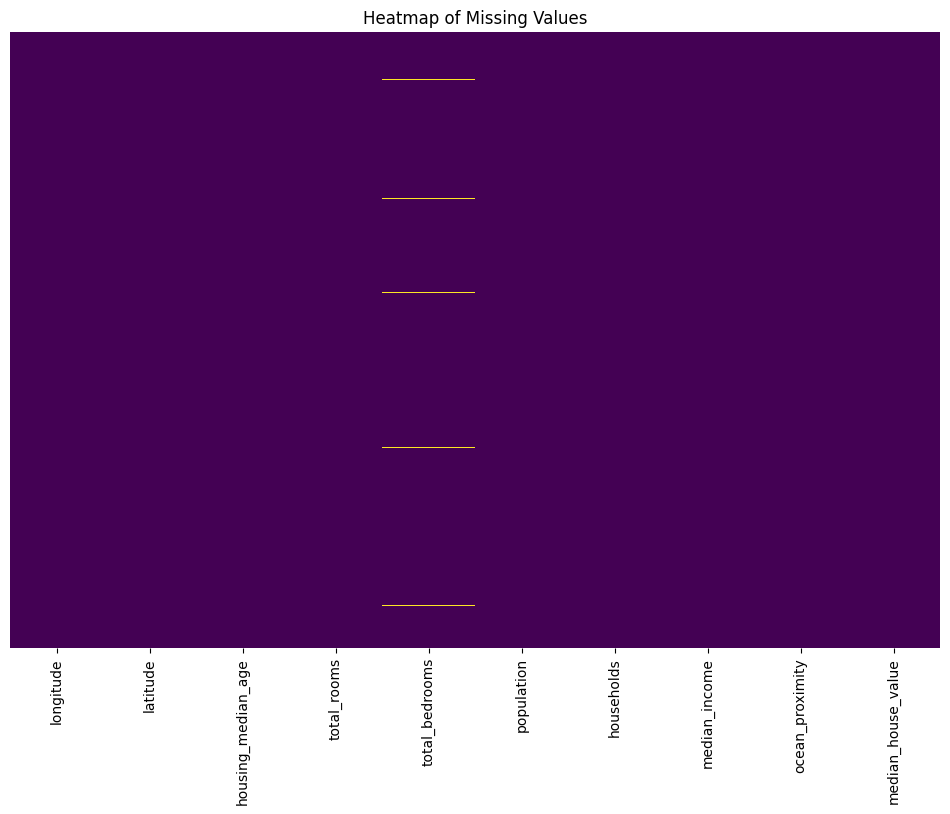

In [139]:
# Membuat dataframe boolean missing value
missing_data = df.isnull()

# Membuat heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(missing_data, cbar=False, cmap='viridis', yticklabels=False)
plt.title('Heatmap of Missing Values')
plt.show()

berdasarkan penelusuran *missing values* diatas, dapat dilihat bahwa terdapat 137 data yang kosong pada fitur **total_bedrooms**

- Imputasi *missing values* dengan Q-Q Plot dan Histogram  
Sebelum mengisi data, perlu dilihat apakah data berdistribusi normal atau tidak. Saya memilih plot Q-Q karena kecocokannya untuk digunakan pada dataset besar.

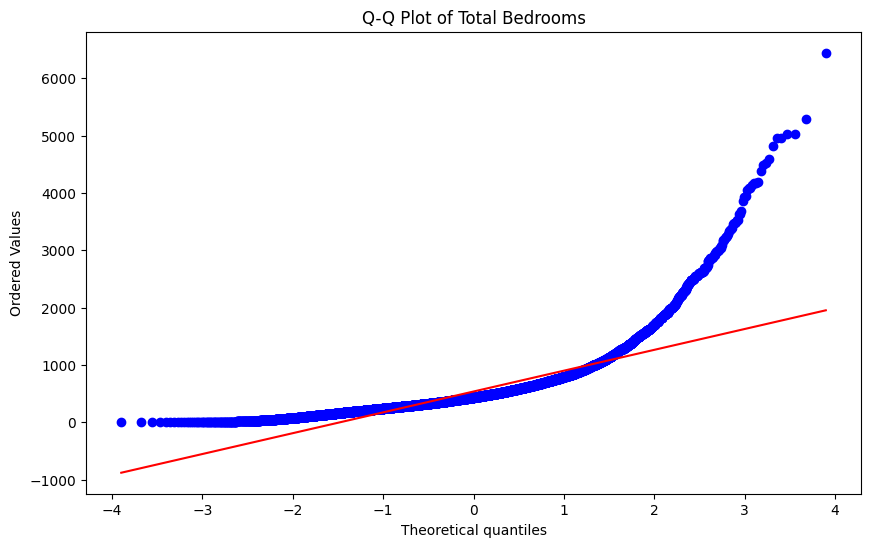

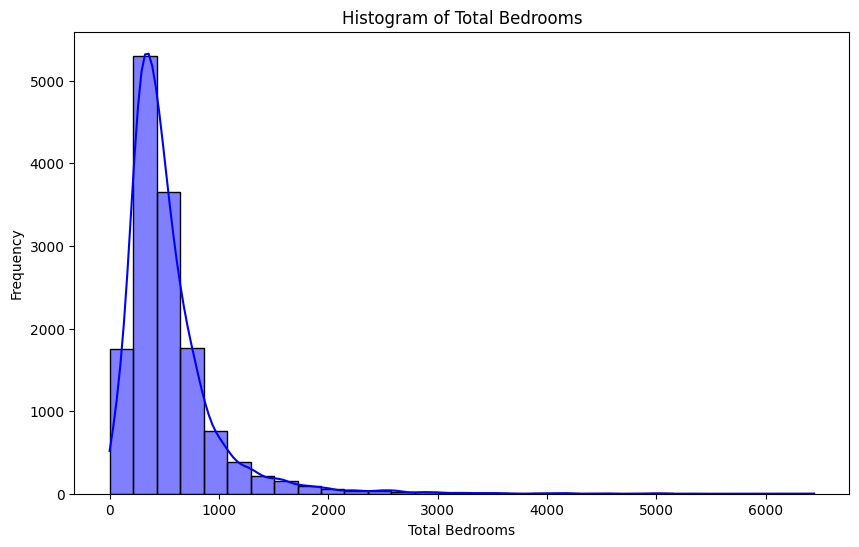

In [140]:
# Select the column to check for normality
df_cleaned = df.copy()
column_name = 'total_bedrooms'

# Q-Q Plot
plt.figure(figsize=(10, 6))
probplot(df_cleaned[column_name].dropna(), dist="norm", plot=plt)
plt.title('Q-Q Plot of Total Bedrooms')
plt.show()

# Histogram and Density Plot
plt.figure(figsize=(10, 6))
sns.histplot(df_cleaned[column_name].dropna(), kde=True, color='blue', bins=30)
plt.title('Histogram of Total Bedrooms')
plt.xlabel('Total Bedrooms')
plt.ylabel('Frequency')
plt.show()

- Plot Q-Q menunjukkan bahwa distribusi tidak normal karena titik-titik data tidak membentuk garis lurus yang mengikuti garis referensi. Oleh karena itu, data yang hilang akan diisi dengan median.

longitude             0
latitude              0
housing_median_age    0
total_rooms           0
total_bedrooms        0
population            0
households            0
median_income         0
ocean_proximity       0
median_house_value    0
dtype: int64

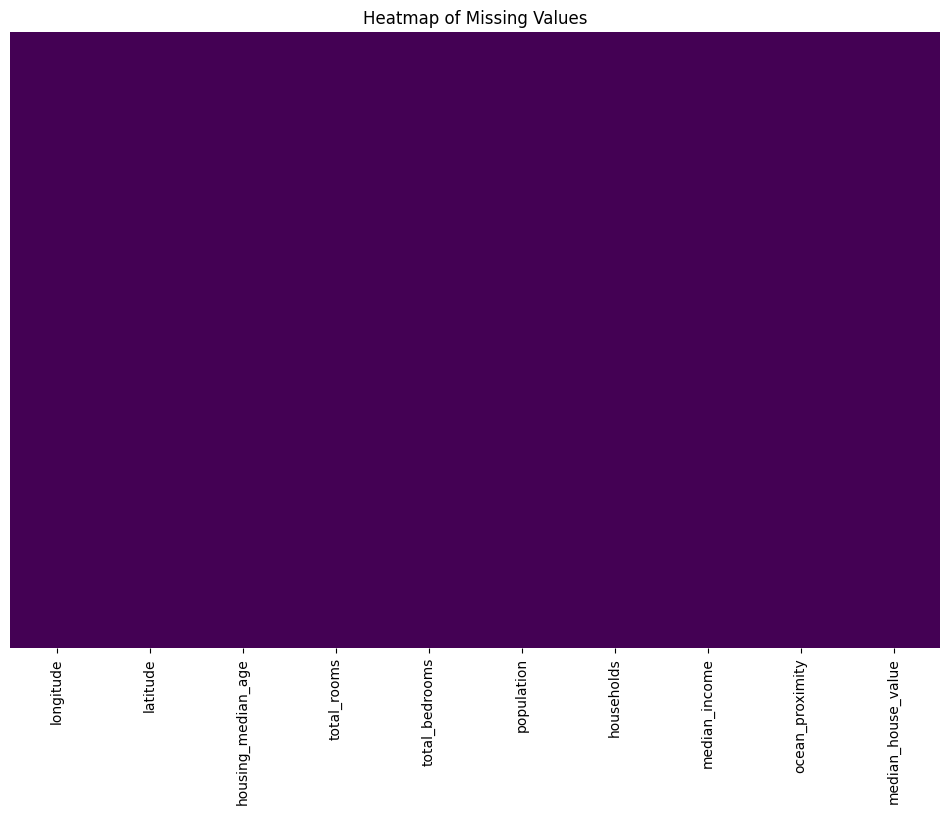

In [141]:
# Mengganti missing values dengan median
imputer = SimpleImputer(strategy='median')
df_cleaned['total_bedrooms'] = imputer.fit_transform(df_cleaned[['total_bedrooms']])

# Membuat dataframe boolean missing value
missing_data = df_cleaned.isnull()

# Menunjukkan jumlah missing values
display(df_cleaned.isna().sum())

# Membuat heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(missing_data, cbar=False, cmap='viridis', yticklabels=False)
plt.title('Heatmap of Missing Values')
plt.show()

pengisian data kosong pada fitur **total_bedrooms** dengan median berhasil.

### 2.3 *Outlier Removal*
Membersihkan dataset dengan cara menghapus outlier menggunakan dua metode:  
- Penghapusan Outlier Berbasis Kuantil dan
- Isolation Forest.

#### 2.3.1 *Quantile Removal*
Menghapus outlier dengan menentukan rentang kuantil antara persentil ke-1 dan ke-99 untuk setiap fitur.


In [142]:
features = [
    'housing_median_age',
    'total_rooms',
    'total_bedrooms',
    'population',
    'households',
    'median_income',
    'median_house_value'
]

# Step 1: Quantile Outlier Removal
lower_quantile = 0.01
upper_quantile = 0.99

for feature in features:
    lower_bound = df_cleaned[feature].quantile(lower_quantile)
    upper_bound = df_cleaned[feature].quantile(upper_quantile)
    df_cleaned = df_cleaned[(df_cleaned[feature] >= lower_bound) & (df_cleaned[feature] <= upper_bound)]

#### 2.3.2 *Isolation Forest*
Algoritma *machine learning* yang mengidentifikasi anomali dalam dataset.

In [143]:
features = [
    'longitude',
    'latitude',
    'housing_median_age',
    'total_rooms',
    'total_bedrooms',
    'population',
    'households',
    'median_income',
    'median_house_value'
]
features_data = df_cleaned[features]
# Isolation Forest model
iso_forest = IsolationForest(contamination=0.05, random_state=42)  # Contamination rate
iso_forest.fit(features_data)

# Prediksi outlier
df_cleaned['outlier'] = iso_forest.predict(features_data)
df_cleaned = df_cleaned[df_cleaned['outlier'] == 1]
df_cleaned.drop(columns=['outlier'], inplace=True)



### 2.4 *Feature Engineering*

#### 2.4.1 Penambahan fitur
berikut adalah fitur yang ingin di tambahkan

- **rooms_per_household**: Rumah yang besar kemungkinan lebih banyak kamar, hal ini berkorelasi dengan nilai rumah yang lebih tinggi begitu juga sebaliknya.

- **bedrooms_per_room**: Rasio perbandingan kamar tidur per tinggi bisa berarti properti lebih besar, berarti kemungkinan nilai rumah lebih tinggi begitu juga sebaliknya.

- **population_per_household**: Kepadatan tinggi bisa menandakan permintaan rumah tinggi yang menyebabkan nilai rumah lebih tinggi begitu juga sebaliknya.

In [144]:
df_engineered = df_cleaned.copy()

df_engineered['rooms_per_household'] = df_engineered['total_rooms'] / df_engineered['households']
df_engineered['bedrooms_per_room'] = df_engineered['total_bedrooms'] / df_engineered['total_rooms']
df_engineered['population_per_household'] = df_engineered['population'] / df_engineered['households']

#### 2.4.2 Penghapusan Fitur
penghapusan fitur dilakukan berdasarkan multikolinearitas antar fitur.

- pertama perlu dilakukan matriks korelasi untuk mengidentifikasikan multikolinearitas

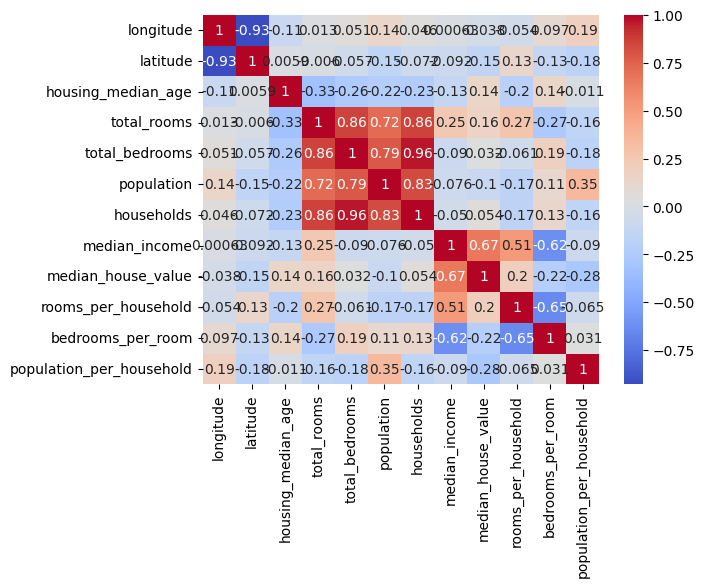

In [145]:
# Matriks korelasi
corr_matrix = df_engineered.select_dtypes(include=['number']).corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()


berdasarkan matriks korelasi diatas, terdapat korelasi tinggi antara 4 fitur, yaitu **total_rooms, total_bedrooms, population** dan **households**. diputuskan untuk tidak menggunakan tiga fitur, yaitu **total_rooms, total_bedrooms** dan **population**.

In [146]:
df_engineered.drop(columns=['total_rooms', 'total_bedrooms', 'households'], inplace=True)

### 2.5 Scaling
RobustScaler digunakan untuk menskalakan fitur numerik dalam dataset karena data tersebut tidak terdistribusi secara normal dan mungkin mengandung *outliers*.

In [147]:
df_scaled = df_engineered.copy()

numeric_features = df_scaled.select_dtypes(include=['float64'])  # Memilih fitur numerik
numeric_features = numeric_features.drop(columns=['median_house_value'])  # Ekslusi kolom yang akan diprediksi


scaler = RobustScaler()
scaled_features = scaler.fit_transform(numeric_features)
df_num = pd.DataFrame(scaled_features, columns=numeric_features.columns)

# Menambahkan kolom yang akan diprediksi
df_scaled = pd.concat([df_num, df_scaled[['median_house_value', 'ocean_proximity']].reset_index(drop=True)], axis=1)

### 2.6 Encoding Variabel Kategorikal
Fitur "ocean_proximity" di *encode* dengan one hot encoding

In [148]:
df_final = pd.get_dummies(df_scaled, columns=['ocean_proximity'])

## 3. Splitting atau Pemisahan Data Set Pelatihan dan Pengujian

In [149]:
X = df_final.drop('median_house_value', axis=1)
y = df_final['median_house_value']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Exploratory Data Analysis (EDA)

## 1. Ringkasan Statistika

In [150]:
display(df_final.describe())

# Tipe data
print(df_final.dtypes)
display(df_final.isna().sum())

longitude      latitude  housing_median_age    population  \
count  12218.000000  12218.000000        12218.000000  12218.000000   
mean      -0.292088      0.361401           -0.020807      0.144753   
std        0.526161      0.564950            0.670485      0.778466   
min       -1.554090     -0.449735           -1.444444     -1.165394   
25%       -0.881266     -0.082011           -0.555556     -0.428753   
50%        0.000000      0.000000            0.000000      0.000000   
75%        0.118734      0.917989            0.444444      0.571247   
max        1.031662      2.039683            1.222222      3.941476   

       median_income  rooms_per_household  bedrooms_per_room  \
count   12218.000000         12218.000000       12218.000000   
mean        0.116821             0.062347           0.155952   
std         0.760501             0.976126           0.889062   
min        -1.177263            -2.574108          -1.959111   
25%        -0.450354            -0.494078          -0.429588   
50%         0.000000             0.000000           0.000000   
75%         0.549646             0.505922           0.570412   
max         3.392144            21.177871          10.966099   

       population_per_household  median_house_value  
count              12218.000000        12218.000000  
mean                   0.124477       203213.651334  
std                    0.922275       108370.951571  
min                   -1.859612        51700.000000  
25%                   -0.451709       121400.000000  
50%                    0.000000       179500.000000  
75%                    0.548291       257775.000000  
max                   21.862174       500001.000000

longitude                     float64
latitude                      float64
housing_median_age            float64
population                    float64
median_income                 float64
rooms_per_household           float64
bedrooms_per_room             float64
population_per_household      float64
median_house_value            float64
ocean_proximity_<1H OCEAN        bool
ocean_proximity_INLAND           bool
ocean_proximity_ISLAND           bool
ocean_proximity_NEAR BAY         bool
ocean_proximity_NEAR OCEAN       bool
dtype: object


longitude                     0
latitude                      0
housing_median_age            0
population                    0
median_income                 0
rooms_per_household           0
bedrooms_per_room             0
population_per_household      0
median_house_value            0
ocean_proximity_<1H OCEAN     0
ocean_proximity_INLAND        0
ocean_proximity_ISLAND        0
ocean_proximity_NEAR BAY      0
ocean_proximity_NEAR OCEAN    0
dtype: int64

## 2. Visualisasi Data

### 2.1 Analisis Univariatif
- Histogram : Memvisualisasikan distribusi fitur numerik
- Bar Plot  : Melihat frekuensi fitur kategorik
- Box Plot  : Mendeteksi outlier dari fitur numerik

#### 2.1.1 df_cleaned

Histogram


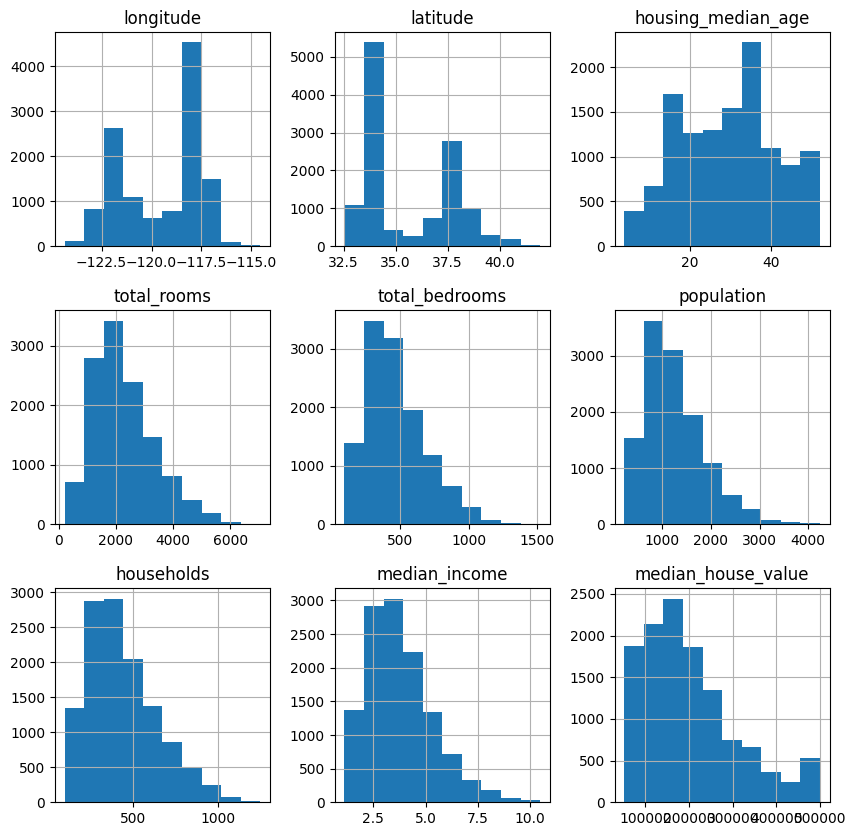

Bar Plot


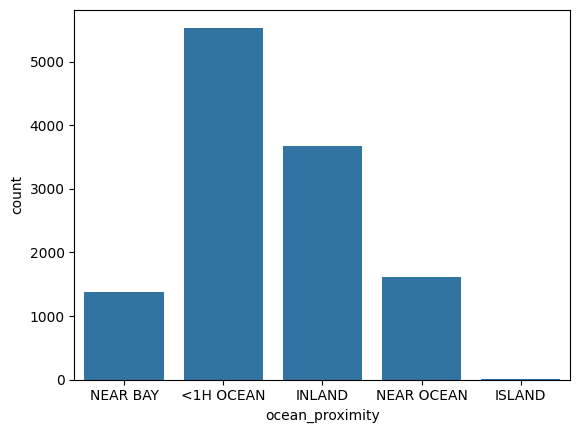

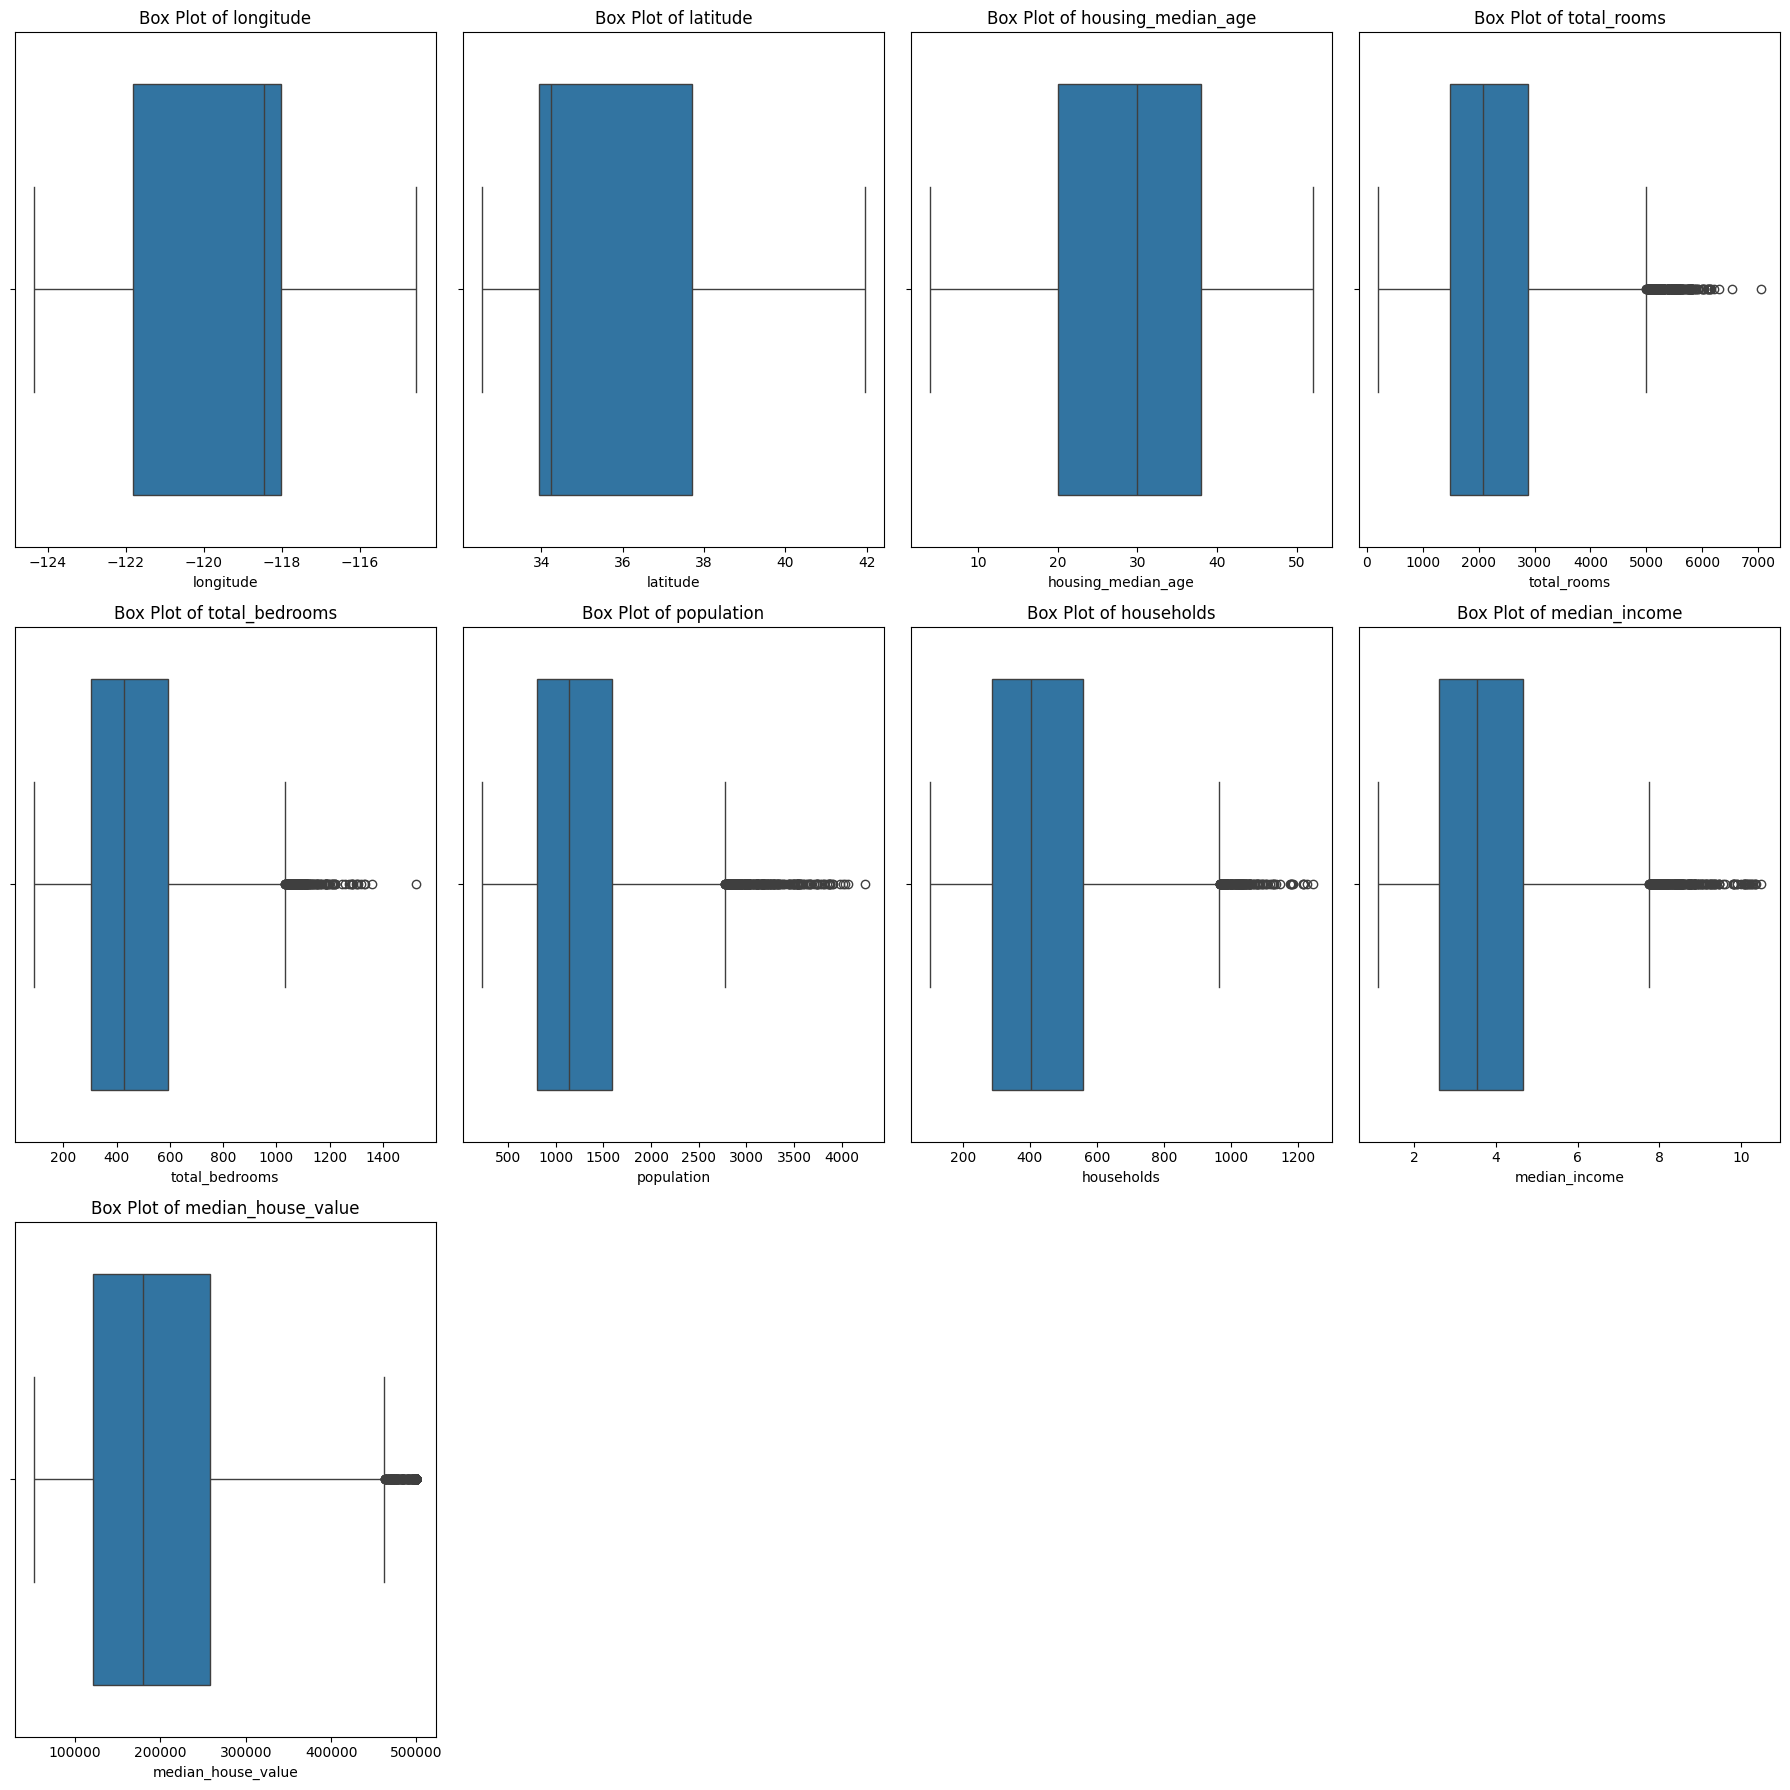

In [151]:
# Histograms
print("Histogram")
df_cleaned.hist(figsize=(10, 10))
plt.show()

# Bar plots untuk fitur kategorikal
print("Bar Plot")
sns.countplot(x='ocean_proximity', data=df_cleaned)
plt.show()

# Box plots untuk fitur numerik
numerical_features = df_cleaned.select_dtypes(include=['float64', 'int64'])
num_cols = numerical_features.shape[1]
num_cols_per_row = 4
num_rows = -(-num_cols // num_cols_per_row)
fig, axes = plt.subplots(num_rows, num_cols_per_row, figsize=(18, 6*num_rows))
if num_rows == 1:
  axes = axes.reshape(1, -1)

# Loop setiap fitur numerik untuk membuat box plot
for i, column in enumerate(numerical_features.columns):
    row = i // num_cols_per_row
    col = i % num_cols_per_row
    sns.boxplot(x=column, data=df_cleaned, ax=axes[row][col])
    axes[row][col].set_title(f'Box Plot of {column}')

# Menghapus subplot yang tidak digunakkan
for i in range(num_cols, num_rows * num_cols_per_row):
    fig.delaxes(axes.flatten()[i])

plt.tight_layout()
plt.show()

#### 2.1.2 df_scaled

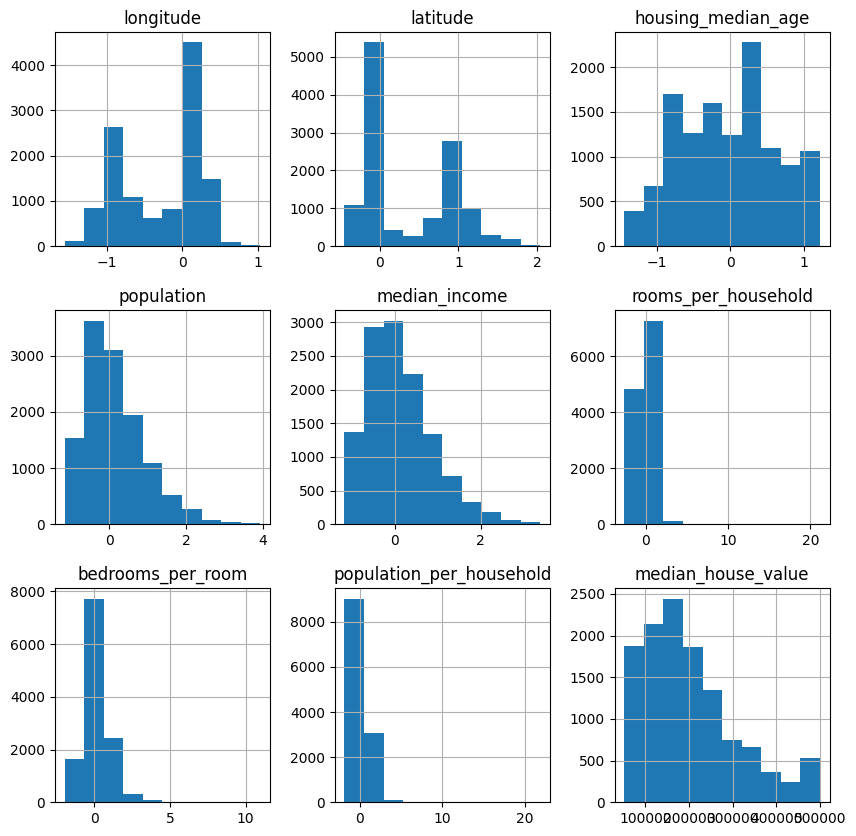

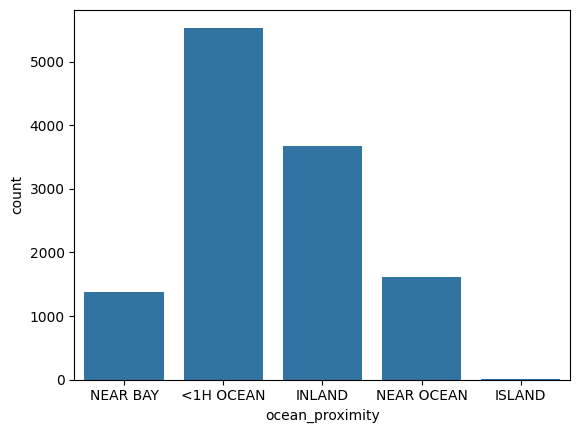

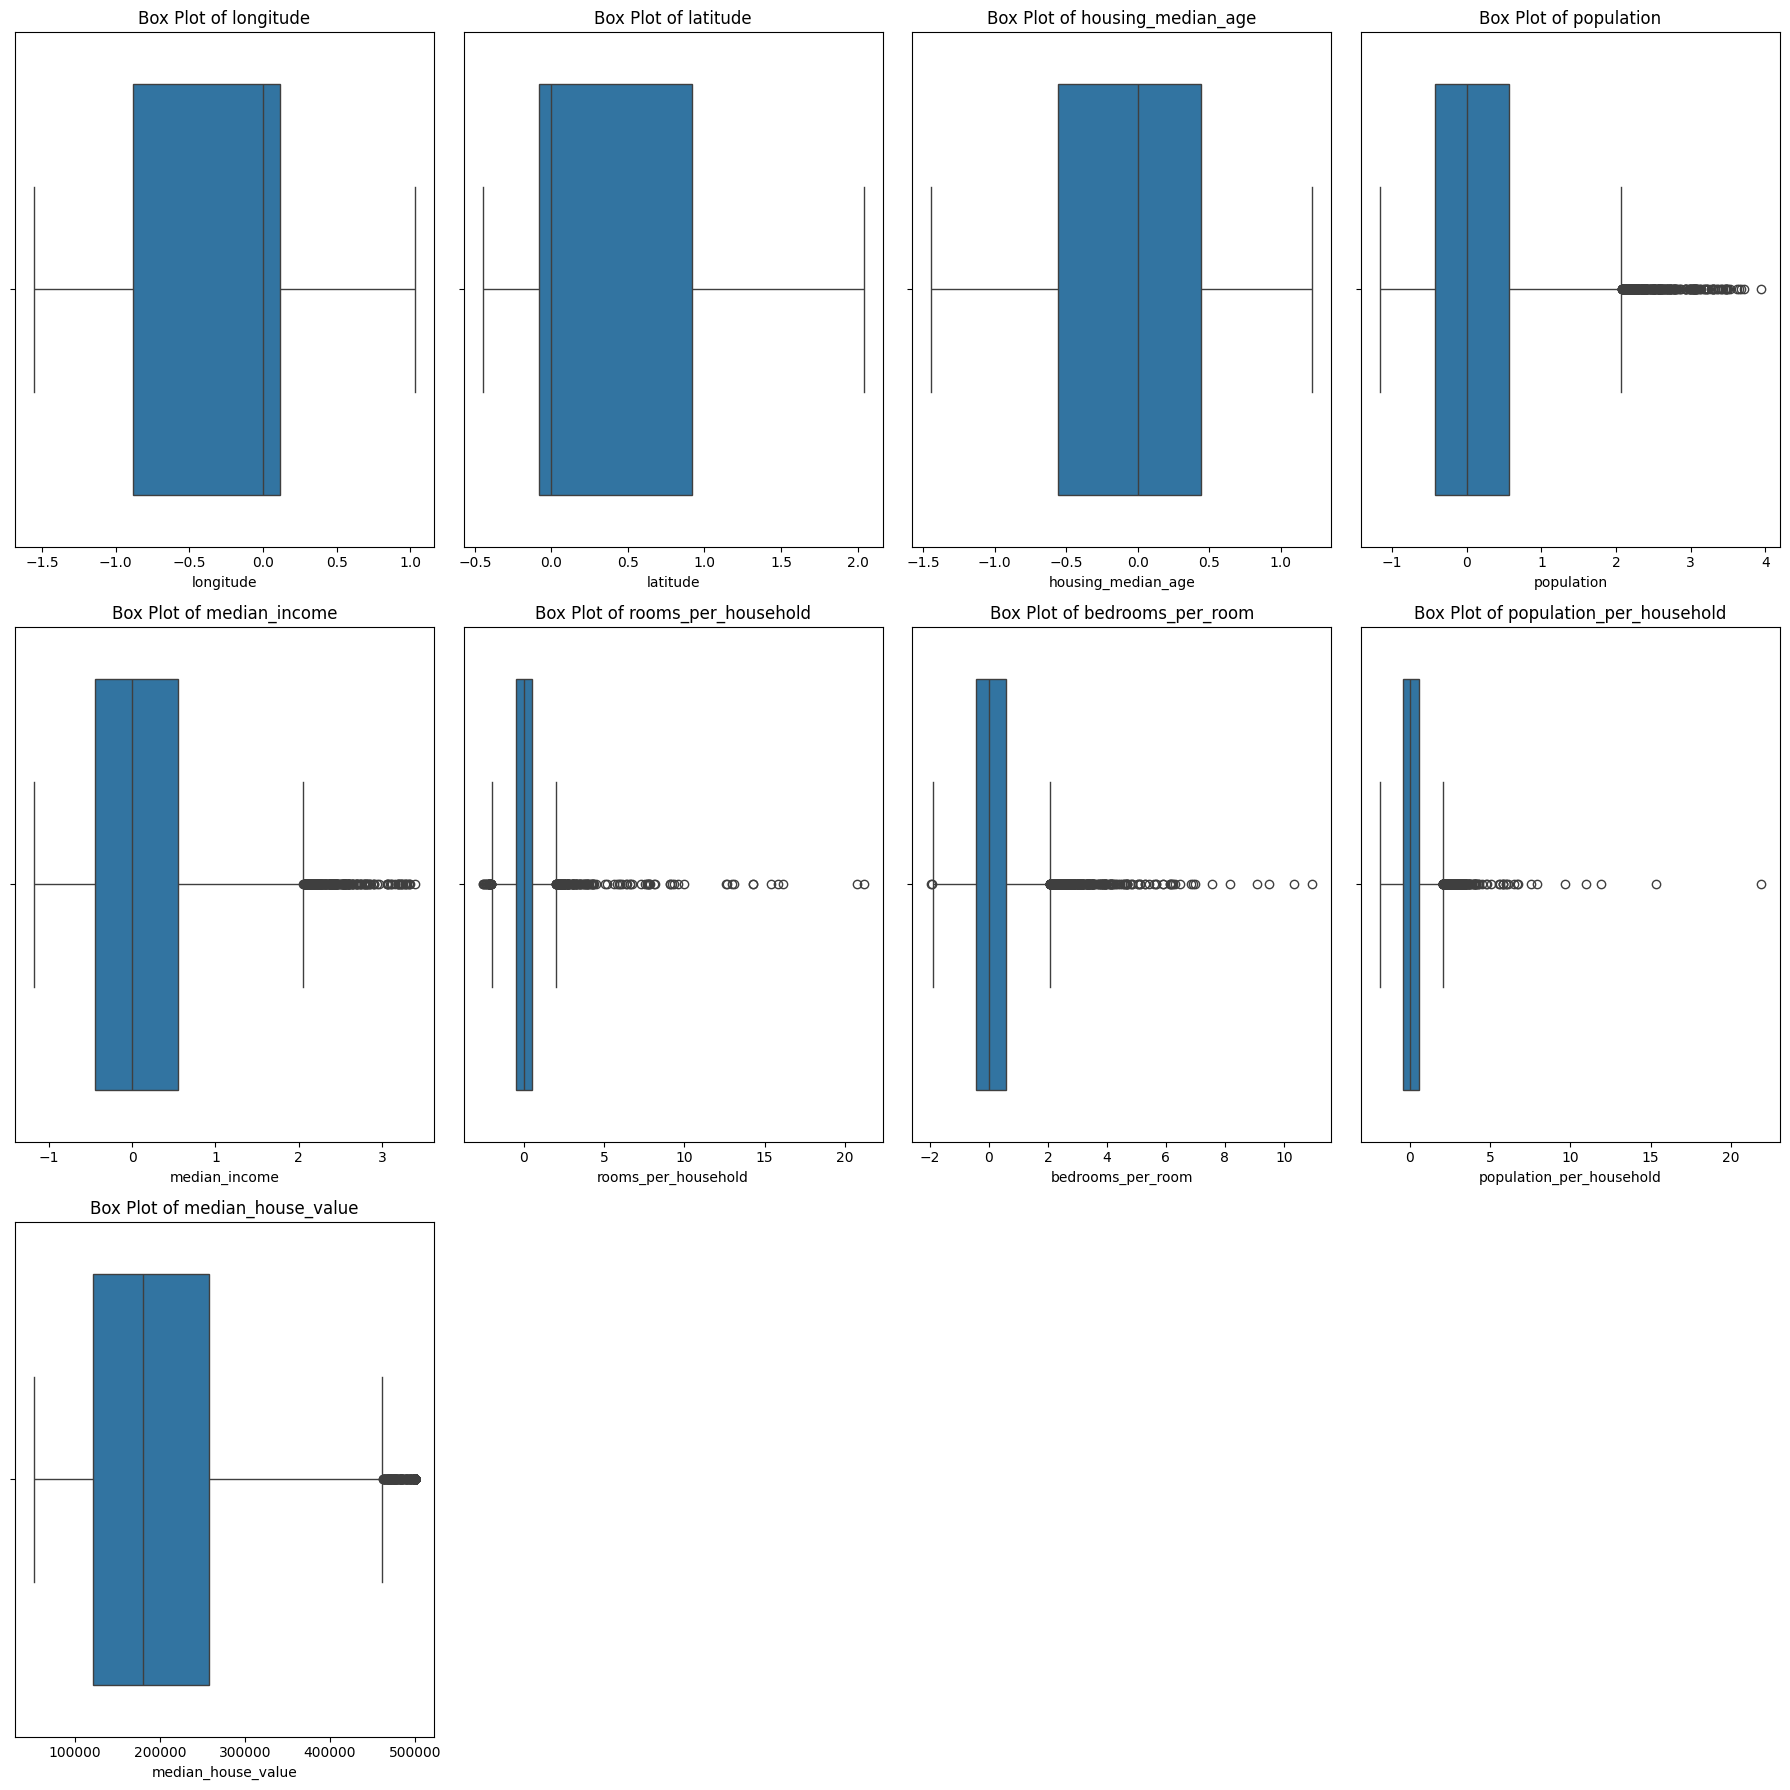

In [152]:
# Histograms
df_scaled.hist(figsize=(10, 10))
plt.show()

# Bar plots untuk fitur kategorikal
sns.countplot(x='ocean_proximity', data=df_scaled)
plt.show()

# Box plots untuk fitur numerik
numerical_features = df_scaled.select_dtypes(include=['float64', 'int64'])
num_cols = numerical_features.shape[1]
num_cols_per_row = 4
num_rows = -(-num_cols // num_cols_per_row)
fig, axes = plt.subplots(num_rows, num_cols_per_row, figsize=(18, 6*num_rows))
if num_rows == 1:
  axes = axes.reshape(1, -1)

# Loop setiap fitur numerik untuk membuat box plot
for i, column in enumerate(numerical_features.columns):
    row = i // num_cols_per_row
    col = i % num_cols_per_row
    sns.boxplot(x=column, data=df_scaled, ax=axes[row][col])
    axes[row][col].set_title(f'Box Plot of {column}')

# Menghapus subplot yang tidak digunakkan
for i in range(num_cols, num_rows * num_cols_per_row):
    fig.delaxes(axes.flatten()[i])

plt.tight_layout()
plt.show()

### 2.2 Analisis Bivariatif
- Scatter Plots: untuk melihat hubungan antara fitur numerik dan variabel target
- Matriks Korelasi: untuk menghitung korelasi antara fitur numerik
- Dampak Fitur Kategorik


#### 2.2.1 df_cleaned

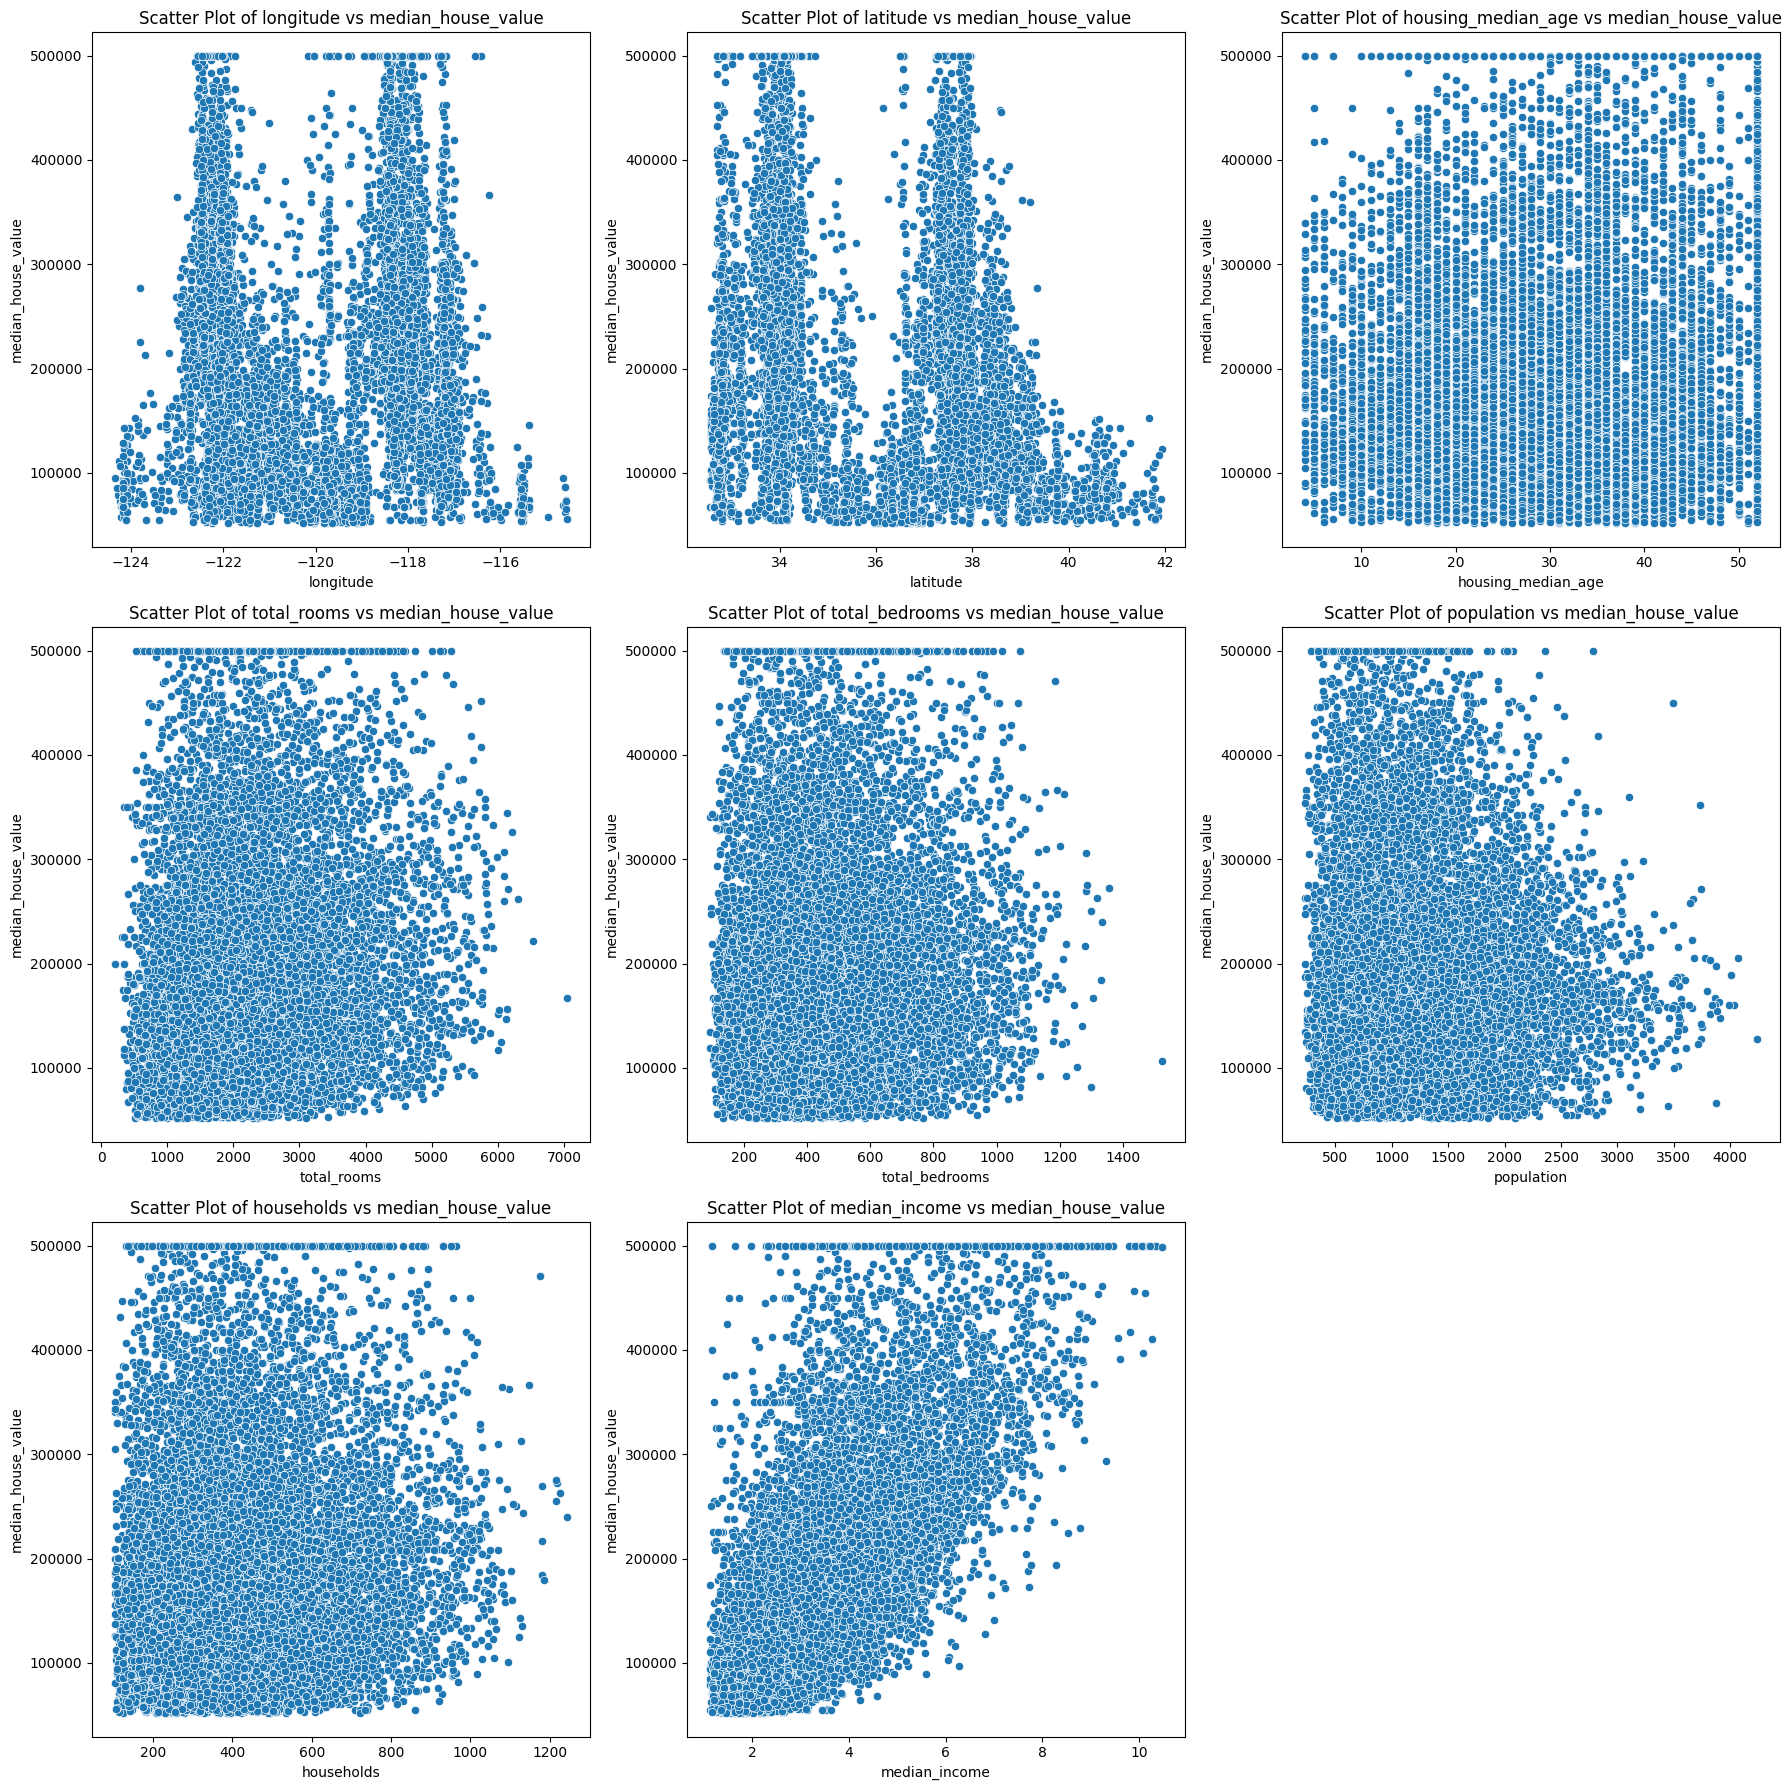

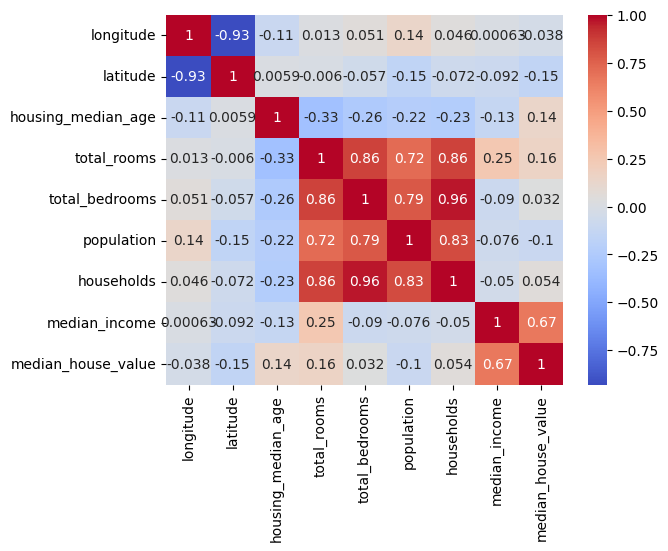

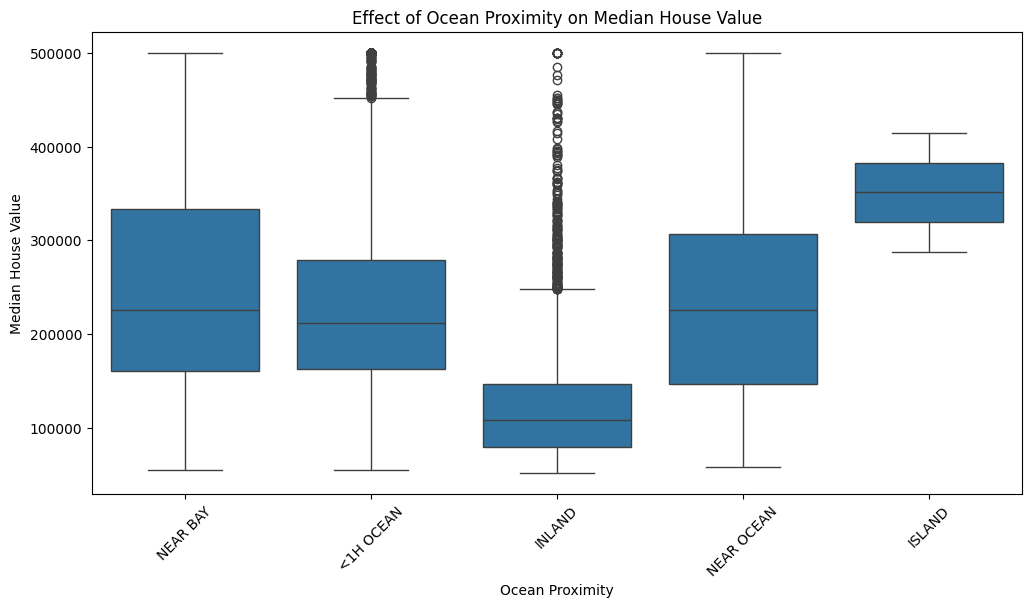

In [153]:
# Scatter plot
numerical_features = df_cleaned.select_dtypes(include=['float64']).columns
target_variable = 'median_house_value'

# Parameter
num_cols_per_row = 3
num_plots_per_figure = 9  # 3 baris per figure (grid 3x3)
num_plots = len(numerical_features) - 1
num_figures = -(-num_plots // num_plots_per_figure)

# Plotting
plot_idx = 0
for fig_num in range(num_figures):
    fig, axes = plt.subplots(3, num_cols_per_row, figsize=(18, 18))
    axes = axes.flatten()

    for ax in axes:
        if plot_idx < num_plots:
            feature = numerical_features[plot_idx]
            if feature != target_variable:
                sns.scatterplot(x=feature, y=target_variable, data=df_cleaned, ax=ax)
                ax.set_title(f'Scatter Plot of {feature} vs {target_variable}')
            plot_idx += 1
        else:
            fig.delaxes(ax)

    plt.tight_layout()
    plt.show()

# Matriks korelasi
corr_matrix = df_cleaned.select_dtypes(include=['number']).corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()

# Dampak fitur kategorik
plt.figure(figsize=(12, 6))
sns.boxplot(x='ocean_proximity', y='median_house_value', data=df_cleaned)
plt.title('Effect of Ocean Proximity on Median House Value')
plt.xlabel('Ocean Proximity')
plt.ylabel('Median House Value')
plt.xticks(rotation=45)
plt.show()

#### 2.2.2 df_scaled

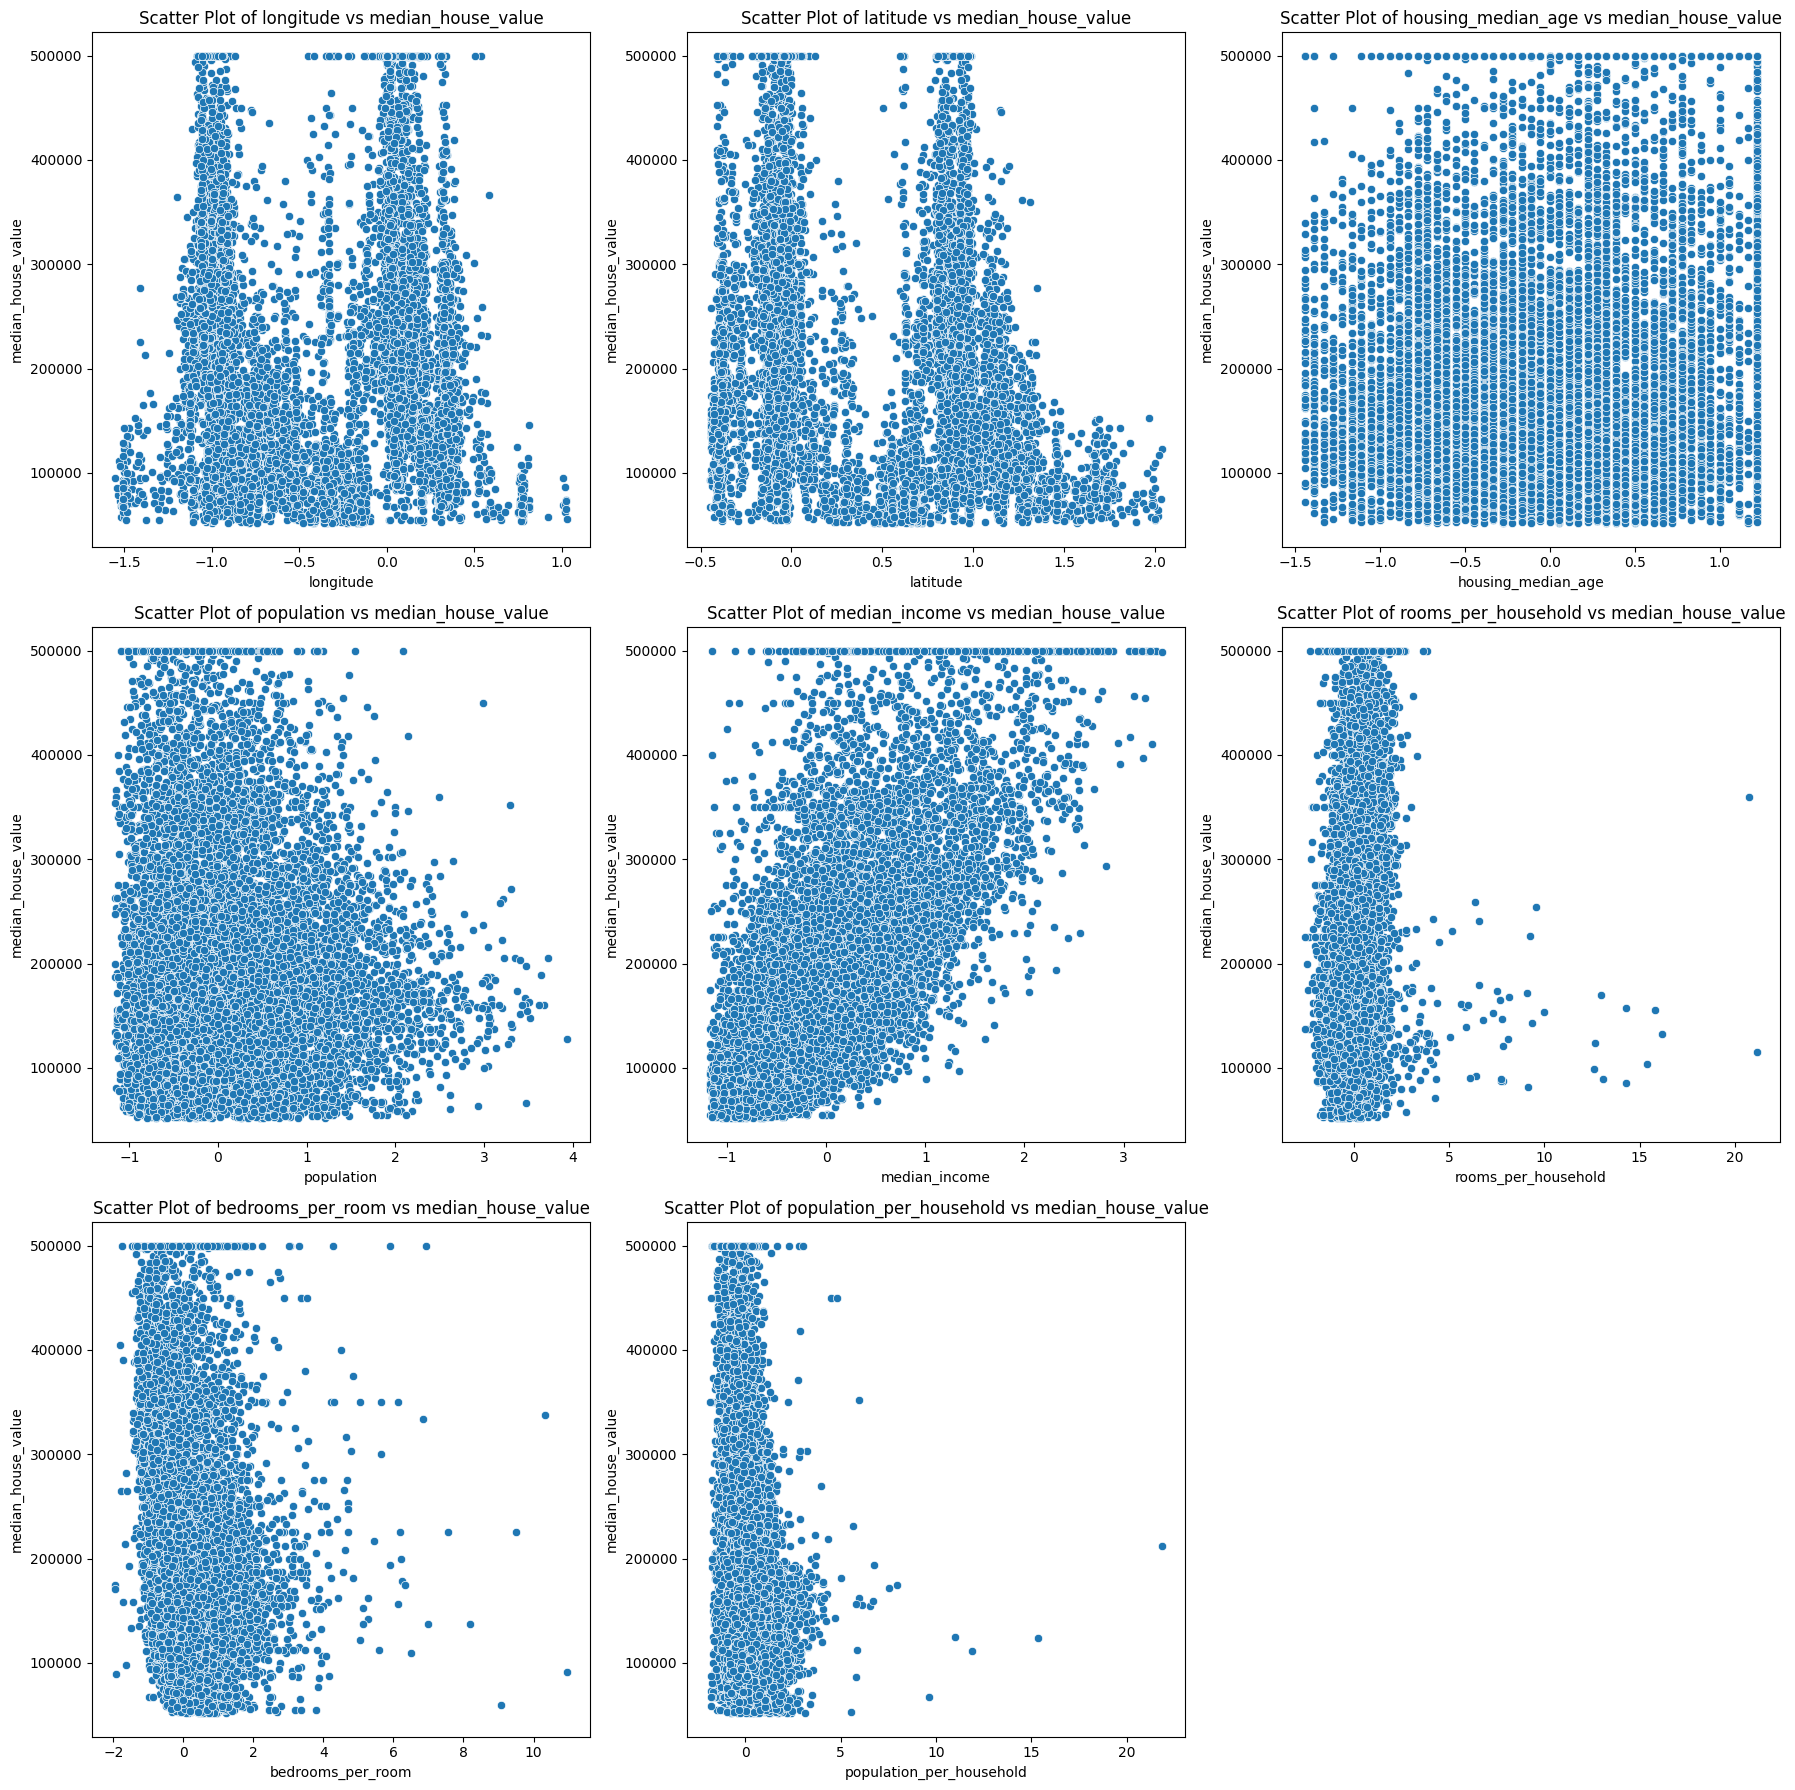

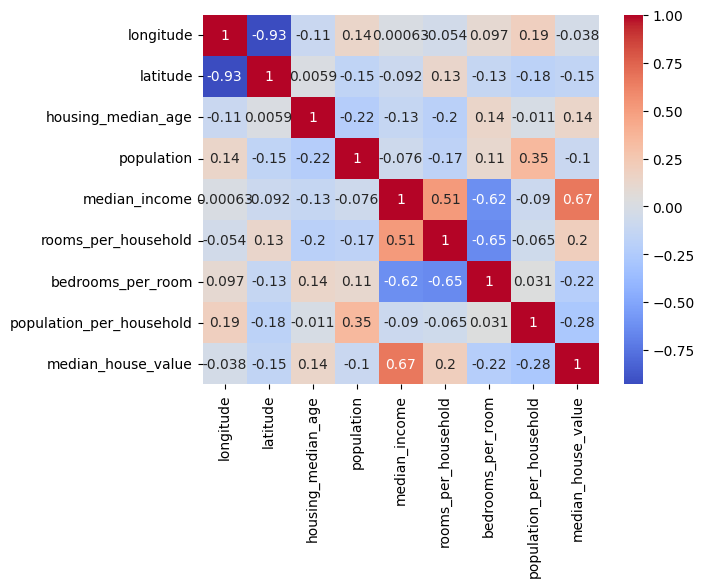

In [154]:
# Scatter plot
numerical_features = df_scaled.select_dtypes(include=['float64']).columns
target_variable = 'median_house_value'

# Parameter
num_cols_per_row = 3
num_plots_per_figure = 9  # 3 baris per figure (grid 3x3)
num_plots = len(numerical_features) - 1
num_figures = -(-num_plots // num_plots_per_figure)

# Plotting
plot_idx = 0
for fig_num in range(num_figures):
    fig, axes = plt.subplots(3, num_cols_per_row, figsize=(18, 18))
    axes = axes.flatten()

    for ax in axes:
        if plot_idx < num_plots:
            feature = numerical_features[plot_idx]
            if feature != target_variable:
                sns.scatterplot(x=feature, y=target_variable, data=df_scaled, ax=ax)
                ax.set_title(f'Scatter Plot of {feature} vs {target_variable}')
            plot_idx += 1
        else:
            fig.delaxes(ax)

    plt.tight_layout()
    plt.show()

# Matriks korelasi
corr_matrix = df_scaled.select_dtypes(include=['number']).corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()

# *Model Benchmarking*

Perlu dilakukan pengujian terhadap beberapa model machine learning untuk menemukan model paling baik.  

Model akan diuji  terdapat 11 model yang terdiri dari 7 base model dan 4 ensemble model.

- Base model:
  - Linear Regression
  - KNN Regressor
  - Decision Tree Regressor
  - Rigde Regression
  - Lasso Regression
  - Elastic Net
  - Huber Regressor

- Ensemble model:
  - Random Forest Regressor
  - Ada Boost Regressor
  - Gradient Boosting Regressor
  - Xtreme Gradient Boosting Regessor



Pertama, dilakukan penetapan variabel untuk melakukan model benchmarking.

In [155]:
# list model yang akan digunakan
lr = LinearRegression()
knn = KNeighborsRegressor()
dt = DecisionTreeRegressor()
r = Ridge()
ls = Lasso()
en = ElasticNet()
hr = HuberRegressor()
rf = RandomForestRegressor()
ada = AdaBoostRegressor()
gb = GradientBoostingRegressor()
xgb = XGBRegressor()

model_names = [
    "Linear Regression",
    "K-Neighbors Regressor",
    "Decision Tree Regressor",
    "Ridge",
    "Lasso",
    "ElasticNet",
    "Huber Regressor",
    "Random Forest Regressor",
    "AdaBoost Regressor",
    "Gradient Boosting Regressor",
    "XGBoost Regressor"
]

model_objects = [
    lr,
    knn,
    dt,
    r,
    ls,
    en,
    hr,
    rf,
    ada,
    gb,
    xgb
]

Selanjutnya, dilakukan pengubahan nama kolom agar dapat diterima oleh model.

In [156]:
def sanitize_feature_names(df):
    df.columns = [
        col if isinstance(col, str) else str(col) for col in df.columns
    ]
    df.columns = df.columns.str.replace('[', '(', regex=False).str.replace(']', ')', regex=False).str.replace('<', 'less_than_', regex=False).str.replace('>', 'greater_than_', regex=False)
    return df

X_train = sanitize_feature_names(X_train)
X_test = sanitize_feature_names(X_test)

Lalu, membuat fungsi **Eva_Matrix_base** untuk melakukan evaluasi model.

In [157]:
def Eva_Matrix_Base(model, X_train, X_test, y_train, y_test, Nama, k=5):
    # Fitting model
    Model = model.fit(X_train, y_train)

    # Prediksi pada data training
    y_pred_tr = Model.predict(X_train)
    R2_train = r2_score(y_train, y_pred_tr)
    MAE_train = mean_absolute_error(y_train, y_pred_tr)
    MSE_train = mean_squared_error(y_train, y_pred_tr)
    RMSE_train = np.sqrt(MSE_train)

    # Validasi k-fold
    cv_scores = cross_val_score(model, X_train, y_train, cv=k, scoring='r2')
    avg_cv_score = np.mean(cv_scores)

    # Prediksi pada data test
    y_pred_ts = Model.predict(X_test)
    R2_test = r2_score(y_test, y_pred_ts)
    MAE_test = mean_absolute_error(y_test, y_pred_ts)
    MSE_test = mean_squared_error(y_test, y_pred_ts)
    RMSE_test = np.sqrt(MSE_test)

    # Pembuatan matriks evaluasi
    eva_data = {
        "Model": Nama,
        "R2 Train": R2_train,
        "MAE Train": MAE_train,
        "RMSE Train": RMSE_train,
        "Average CV R2 Train": avg_cv_score,
        "R2 Test": R2_test,
        "MAE Test": MAE_test,
        "RMSE Test": RMSE_test
    }
    df = pd.DataFrame([eva_data])

    return df

Terakhir, menjalankan fungsi **Eva_Matrix_base** dalam loop yang kemudian mencatat hasilnya ke dalam **final_evaluation_df**.

In [158]:
all_evaluation_results = []

# Loop setiap model
for name, model in zip(model_names, model_objects):
    evaluation_result = Eva_Matrix_Base(model, X_train, X_test, y_train, y_test, name)
    all_evaluation_results.append(evaluation_result)

final_evaluation_df = pd.concat(all_evaluation_results, ignore_index=True)

print(final_evaluation_df)

                          Model  R2 Train     MAE Train    RMSE Train  \
0             Linear Regression  0.652944  46753.787567  63552.312635   
1         K-Neighbors Regressor  0.814431  32151.348005  46471.269117   
2       Decision Tree Regressor  1.000000      0.000000      0.000000   
3                         Ridge  0.652919  46749.673169  63554.560514   
4                         Lasso  0.652943  46753.476999  63552.352455   
5                    ElasticNet  0.495480  58074.084018  76624.999790   
6               Huber Regressor  0.643595  45841.135419  64402.565939   
7       Random Forest Regressor  0.971994  11985.119408  18053.435909   
8            AdaBoost Regressor  0.489068  66053.463169  77110.396194   
9   Gradient Boosting Regressor  0.806344  33659.948619  47473.002699   
10            XGBoost Regressor  0.961275  15094.103885  21228.772111   

    Average CV R2 Train   R2 Test      MAE Test     RMSE Test  
0              0.651491  0.666495  46858.735411  63691.9532

# *Model Evaluation*

## Analisis Hasil *Model Benchmarking*

Perlu dilakukan evaluasi terhadap hasil dari *model benchmarking*. hal ini bisa dilakukan dengan membandingkan nilai R<sup>2</sup>, MAE dan RMSE.

In [159]:
display(final_evaluation_df)

Model  R2 Train     MAE Train    RMSE Train  \
0             Linear Regression  0.652944  46753.787567  63552.312635   
1         K-Neighbors Regressor  0.814431  32151.348005  46471.269117   
2       Decision Tree Regressor  1.000000      0.000000      0.000000   
3                         Ridge  0.652919  46749.673169  63554.560514   
4                         Lasso  0.652943  46753.476999  63552.352455   
5                    ElasticNet  0.495480  58074.084018  76624.999790   
6               Huber Regressor  0.643595  45841.135419  64402.565939   
7       Random Forest Regressor  0.971994  11985.119408  18053.435909   
8            AdaBoost Regressor  0.489068  66053.463169  77110.396194   
9   Gradient Boosting Regressor  0.806344  33659.948619  47473.002699   
10            XGBoost Regressor  0.961275  15094.103885  21228.772111   

    Average CV R2 Train   R2 Test      MAE Test     RMSE Test  
0              0.651491  0.666495  46858.735411  63691.953284  
1              0.711485  0.719952  39436.495499  58364.617483  
2              0.595536  0.636144  43222.459902  66527.012073  
3              0.651508  0.666432  46858.874040  63697.975729  
4              0.651490  0.666487  46859.042550  63692.673405  
5              0.494867  0.499349  59203.760284  78037.061383  
6              0.642883  0.655223  45996.514977  64759.347551  
7              0.795532  0.803943  32304.038678  48834.201787  
8              0.456092  0.496367  67041.013110  78269.089507  
9              0.779744  0.786725  35758.920944  50933.478098  
10             0.822320  0.840359  29466.408171  44066.245191

Berdasarkan hasil ada 3 kandidat yang mungkin dipilih sebagai model. namun model yang dipilih adalah model ensemble XGBoost.

Kandidat:
- K-Neighbors Regressor:  
  - Meskipun K-Neighbors Regressor menunjukkan R<sup>2</sup> rata-rata yang baik pada data training (0.711485) dan data test (0.719952), serta nilai MAE dan RMSE yang cukup rendah pada data test, namun performanya tidak sebaik XGBoost Regressor.
  - Model ini mungkin kurang mampu menangkap pola-pola yang kompleks dalam data dibandingkan dengan XGBoost Regressor.

- Random Forest Regressor:  
  - Random Forest Regressor menunjukkan R<sup>2</sup> rata-ratayang cukup pada data training (0.795456), yang menunjukkan kemampuannya untuk menangkap pola-pola dalam data training dengan cukup baik.
  - Namun, Random Forest Regressor memiliki R<sup>2</sup> yang sedikit lebih rendah pada data test (0.802884) dibandingkan dengan XGBoost Regressor.

- Gradient Boosting Regressor:
  - Gradient Boosting Regressor juga menunjukkan performa yang cukup baik dengan R<sup>2</sup> rata-rata pada data training sebesar (0.779800) dan R<sup>2</sup> pada data test sebesar (0.786731).
  - Namun, meskipun performanya hampir sebanding dengan XGBoost Regressor, hasil evaluasi menunjukkan bahwa XGBoost Regressor lebih unggul dalam hal R<sup>2</sup>, MAE, dan RMSE pada data test.

Model yang dipilih:   
  - XGBoost:  
    - R<sup>2</sup> Train Tinggi: Model XGBoost memiliki R<sup>2</sup> pada data training sebesar 0.961275, yang artinya sekitar 96.13% dari variabilitas dalam data target dapat dijelaskan oleh model. Ini menunjukkan bahwa model XGBoost mampu menangkap pola-pola yang kompleks dalam data training.

    - MAE dan RMSE Rendah pada Data Test: Nilai Mean Absolute Error (MAE) dan Root Mean Squared Error (RMSE) pada data test model XGBoost adalah yang terendah dibandingkan dengan model-model lainnya. MAE sebesar 29466.408171 dan RMSE sebesar 44066.245191 menunjukkan bahwa model XGBoost memiliki tingkat kesalahan prediksi yang rendah, artinya prediksinya lebih dekat dengan nilai sebenarnya pada data test.

    - R<sup>2</sup> Test Tinggi: Model XGBoost juga memiliki R<sup>2</sup> yang tinggi pada data test sebesar 0.840359. Ini menunjukkan bahwa model ini memiliki kemampuan yang baik untuk melakukan generalisasi dari data training ke data baru yang tidak pernah dilihat sebelumnya.

    - Average CV R<sup>2</sup> Train Tinggi: Hasil cross-validation menunjukkan bahwa model XGBoost memiliki R<sup>2</sup> rata-rata yang tinggi pada data training sebesar 0.822320. Ini menunjukkan bahwa model XGBoost konsisten dalam performanya dan tidak terlalu overfitting terhadap data training.

## Gambaran Umum XGBoost

XGBoost (Extreme Gradient Boosting) adalah perpustakaan pembelajaran mesin yang populer dan kuat yang sangat cocok untuk data terstruktur/tabular. Dikembangkan oleh Tianqi Chen dan kontributor dari komunitas DMLC XGBoost, XGBoost dirancang untuk menjadi sangat efisien, fleksibel, dan portabel. XGBoost mengimplementasikan algoritma pembelajaran mesin di bawah kerangka kerja Gradient Boosting. Ia menyediakan penguat pohon paralel yang memecahkan banyak masalah ilmu data dengan cara yang cepat dan akurat.

Fitur utama dari XGBoost meliputi:

- **Kecepatan dan Kinerja**: XGBoost dikenal karena kecepatan dan kinerjanya yang tinggi. Ia mendukung pemrosesan paralel, yang secara signifikan mempercepat proses pelatihan.
- **Regularisasi**: XGBoost memiliki built-in regularisasi L1 dan L2, yang membantu mencegah overfitting dan meningkatkan generalisasi model.
- **Penanganan Data yang Hilang**: XGBoost dapat menangani nilai yang hilang secara internal, membuatnya tangguh terhadap dataset yang tidak lengkap.
- **Fleksibilitas**: XGBoost mendukung berbagai fungsi objektif, termasuk regresi, klasifikasi, dan ranking, serta kompatibel dengan beberapa antarmuka seperti Python, R, Julia, dan Scala.

Untuk informasi lebih lanjut, Anda dapat merujuk ke [dokumentasi resmi XGBoost](https://xgboost.readthedocs.io/).



# *Hyperparameter Tuning*

Grid Search untuk menemukan hyperparameter terrbaik model XGBoost Regressor

In [160]:
xgb_sklearn = XGBRegressor()

# Grid hyperparameter
param_grid = {
    'n_estimators': [500],
    'max_depth': [7],
    'learning_rate': [0.1],
    'subsample': [0.8],
    'colsample_bytree': [0.6, 0.8]
} # Parameter yang diuji sudah banyak, namun diatas hanya dimasukkan sedikit untuk mengurangi waktu running

# Grid untuk search object
grid_search = GridSearchCV(estimator=xgb_sklearn, param_grid=param_grid, cv=5, scoring='r2')

# Melakukan grid search
grid_search.fit(X_train, y_train)

# hyperparameter terbaik
best_params = grid_search.best_params_
best_estimator = grid_search.best_estimator_

Berikutnya, dijalankan kode untuk melihat parameter, R<sup>2</sup>, MAE dan RMSE dari hyperparameter yang menghasilkan nilai paling optimal.

In [161]:
# Evaluasi estimator terbaik
best_estimator.fit(X_train, y_train)
test_score = best_estimator.score(X_test, y_test)

y_pred = best_estimator.predict(X_test)

# Menghitung MAE dan RMSE
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)

# Print hyperparameter terbaik , test score, MAE and RMSE
print("Best Hyperparameters:", best_params)
print("Test Score (R2):", test_score)
print("Mean Absolute Error (MAE):", mae)
print("Root Mean Squared Error (RMSE):", rmse)

Best Hyperparameters: {'colsample_bytree': 0.6, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 500, 'subsample': 0.8}
Test Score (R2): 0.8468319879235683
Mean Absolute Error (MAE): 28586.698328495808
Root Mean Squared Error (RMSE): 43163.5596254292


Berikut adalah parameter dan nilai yang didapat:  
- Parameter Hyperparameter Terbaik:
  - colsample_bytree: 0.6
  - learning_rate: 0.1
  - max_depth: 7
  - n_estimators: 500
  - subsample: 0.8
- Test Score:  
  - R<sup>2</sup>: 0.8468319879235683
  - MAE: 28586.698328495808
  - RMSE: 43163.5596254292

# Interpretasi Model

Interpretasi model merupakan langkah penting dalam analisis data dan pembuatan keputusan karena memberikan pemahaman yang mendalam tentang bagaimana model bekerja dan faktor-faktor apa yang mempengaruhi prediksi yang dihasilkan.
- *Feature importance* analisis
- SHAP Values


## 1. *Feature Importance Analysis*

*Feature Importance Analysis* adalah proses yang penting dalam pemodelan data untuk memahami kontribusi masing-masing fitur terhadap prediksi atau hasil yang diinginkan.

In [170]:
importance = best_estimator.feature_importances_

# Create a DataFrame to store feature names and their importance scores
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': importance})

# Sort the DataFrame by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Print or visualize the feature importance
display(feature_importance_df)

Feature  Importance
9       ocean_proximity_INLAND    0.580875
4                median_income    0.112025
11    ocean_proximity_NEAR BAY    0.074883
7     population_per_household    0.042725
8    ocean_proximity_<1H OCEAN    0.034129
0                    longitude    0.030732
12  ocean_proximity_NEAR OCEAN    0.027012
1                     latitude    0.025549
5          rooms_per_household    0.017495
6            bedrooms_per_room    0.016566
2           housing_median_age    0.015729
10      ocean_proximity_ISLAND    0.013510
3                   population    0.008770

Selanjutnya dilakukan visualisasi dari *Feature Importance Analysis*.

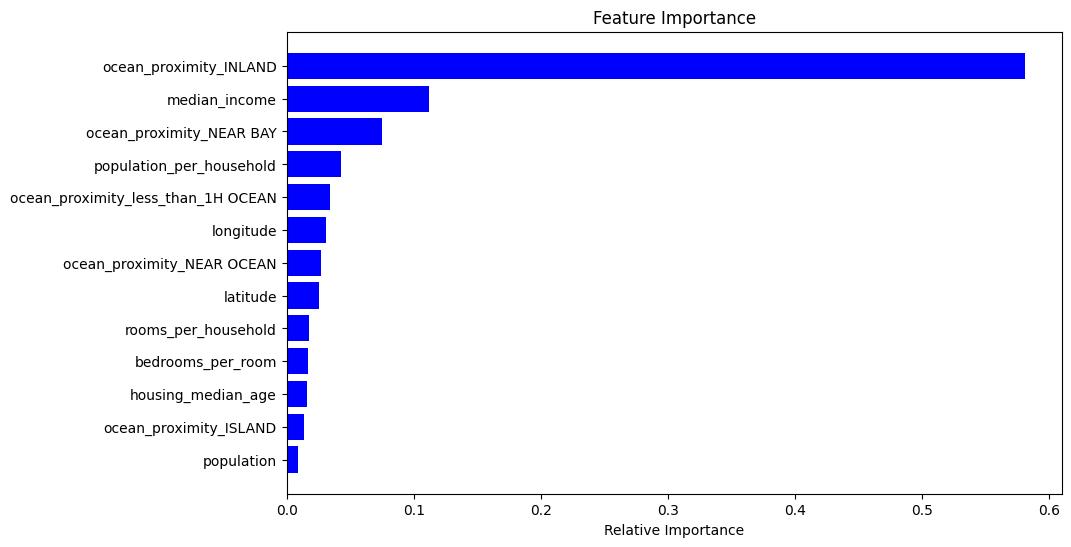

In [171]:
# Mendapatkan skor importance
importance = best_estimator.feature_importances_
# Mengurutkan fitur
indices = np.argsort(importance)

# Membuat plot
plt.figure(figsize=(10, 6))
plt.title('Feature Importance')
plt.barh(range(len(indices)), importance[indices], color='b', align='center')
plt.yticks(range(len(indices)), [X_train.columns[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

Berdasarkan grafik diatas, tampaknya kedekatan perumahan dengan daerah pedalaman (ocean_proximity_INLAND) adalah fitur paling penting, diikuti oleh median_income, dan kedekatan dengan NEAR BAY. Fitur lain seperti population_per_household, longitude, dan latitude juga berkontribusi pada model, meskipun dalam tingkat yang lebih rendah.

Namun untuk mendapatkan insight lebih lanjut, perlu dilakukan analisis SHAP

## 2. SHAP

- Penjelasan Grafik SHAP Beeswarm

  - Sumbu:  
      - **Sumbu x** mewakili nilai SHAP, yang menunjukkan dampak setiap fitur pada output model. Nilai SHAP bisa positif atau negatif, menunjukkan seberapa besar kontribusi fitur tertentu dalam meningkatkan atau menurunkan prediksi.
      - **Sumbu y** mencantumkan fitur-fitur yang digunakan dalam model, diurutkan berdasarkan kepentingannya (nilai absolut rata-rata dari nilai SHAP-nya).

  - Warna:  
      Warna titik-titik menunjukkan nilai fitur, dengan gradasi dari biru (nilai rendah) ke merah (nilai tinggi). Ini membantu memahami hubungan antara nilai fitur dan dampaknya pada prediksi.

  - Distribusi Titik:  
      - Setiap titik pada plot mewakili satu prediksi dari dataset. Posisi titik sepanjang sumbu x menunjukkan nilai SHAP untuk fitur dan instance tersebut.
      - Distribusi titik yang lebih lebar sepanjang sumbu x menunjukkan bahwa fitur tersebut memiliki dampak yang lebih signifikan pada prediksi model.


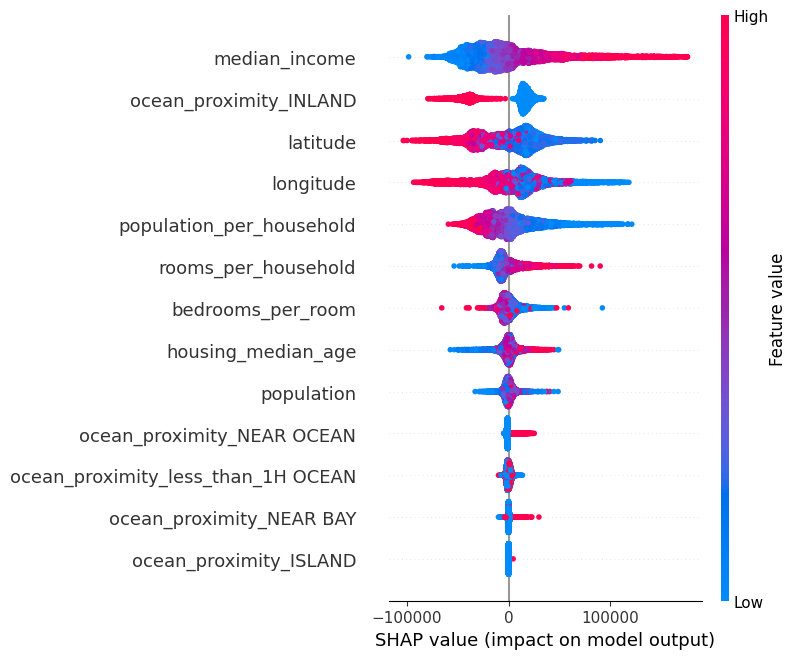

In [164]:
# Membuat SHAP explainer
explainer = shap.TreeExplainer(best_estimator)
shap_values = explainer.shap_values(X_train)

# Plot
shap.summary_plot(shap_values, X_train)

Grafik SHAP beeswarm ini memberikan visualisasi komprehensif tentang pentingnya fitur dan dampaknya terhadap prediksi model. Berikut adalah penjelasan rinci tentang grafik ini:

- Pengamatan Utama

  - *Feature importance*:  
      - **median_income**: Fitur ini memiliki dampak paling signifikan pada prediksi model. Pendapatan median tinggi (merah) umumnya meningkatkan nilai prediksi, sedangkan pendapatan median rendah (biru) menurunkannya.
      - **ocean_proximity_INLAND**: Fitur ini juga memiliki dampak besar. jika rumah berada jauh dari laut, maka akan secara signifikan menurunkan nilai prediksi.
      - **Latitude** dan **Longitude**:  
      Fitur geografis ini sangat penting, dengan variasi nilainya secara signifikan mempengaruhi prediksi.

  - *Feature impact*:  
      - **median_income**: Pendapatan median yang lebih tinggi memiliki dampak positif yang kuat pada output prediksi.
      - **ocean_proximity_INLAND**: Properti yang berada di daratan cenderung menurunkan nilai prediksi, seperti yang ditunjukkan oleh konsentrasi titik merah dengan nilai SHAP negatif.
      - **Latitude** dan **Longitude**: Dampak fitur-fitur ini bervariasi luas, seperti yang terlihat dari penyebaran titik-titik di sepanjang sumbu nilai SHAP.

  - Interaksi:  
      Interaksi antara nilai fitur dan dampaknya pada prediksi juga dapat diamati. Misalnya, fitur seperti rooms_per_household dan bedrooms_per_room menunjukkan pola yang kompleks, menunjukkan bahwa dampaknya bervariasi tergantung pada nilainya.

- Ringkasan

Plot SHAP beeswarm ini memberikan pandangan mendetail tentang bagaimana setiap fitur berkontribusi pada prediksi model. Fitur seperti **median_income** dan kedekatan dengan laut memiliki dampak signifikan, dengan nilai **median_income** yang tinggi secara kuat meningkatkan prediksi, sedangkan berada jauh dari laut secara kuat menurunkannya. Gradasi warna membantu dalam memahami efek dari berbagai nilai fitur pada prediksi.

# Kesimpulan <a id="kesimpulan"></a>

Berikut adalah perbandingan antara hasil prediksi model dan data aktual **California Housing Price**

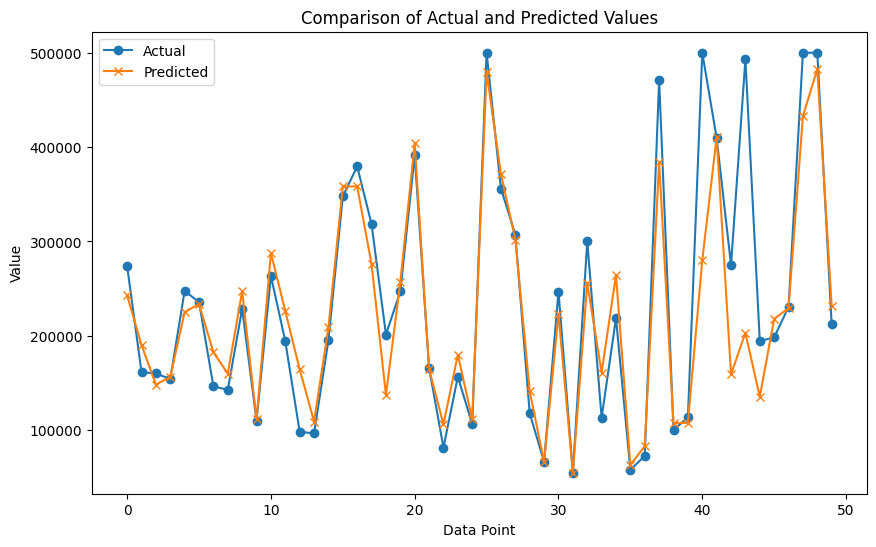

In [165]:
y_test.reset_index(drop=True, inplace=True)

actual_50 = y_test[:50]
pred_50 = y_pred[:50]

plt.figure(figsize=(10, 6))
plt.plot(actual_50, label='Actual', marker='o')
plt.plot(pred_50, label='Predicted', marker='x')
plt.title('Comparison of Actual and Predicted Values')
plt.xlabel('Data Point')
plt.ylabel('Value')
plt.legend()
plt.show()

## 1. Kesimpulan Umum
- Dataset: Dataset yang digunakan adalah dataset harga rumah di California.

- Pemilihan Model Terbaik: Dari 11 model yang dievaluasi, model terbaik dipilih berdasarkan metrik R<sup>2</sup>, MAE, dan RMSE. Model yang dipilih adalah XGBoost.

- Parameter Hyperparameter Terbaik:
  - colsample_bytree: 0.6
  - learning_rate: 0.1
  - max_depth: 7
  - n_estimators: 500
  - subsample: 0.8

- Kinerja Model pada Data Uji:
  - Skor R<sup>2</sup>: **0.8468319879235683**,  
  menunjukkan bahwa model dapat memprediksi sekitar 84.68% variabilitas dalam harga rumah di California, mengindikasikan hubungan yang kuat antara variabel independen (fitur) dan variabel dependen (harga rumah). Ini menunjukkan bahwa prediksi model sangat akurat dan andal, sehingga berguna untuk memprediksi nilai rumah.
  - Mean Absolute Error (MAE): **28586.698328495808**,  
  menunjukkan rata-rata kesalahan absolut prediksi harga rumah adalah sekitar \$28,586. Nilai MAE yang lebih rendah diinginkan, dan \$28,586 adalah relatif rendah, mengindikasikan bahwa prediksi model umumnya dekat dengan harga sebenarnya.
  - Root Mean Squared Error (RMSE): **43163.5596254292**,  
  menunjukkan akar kuadrat dari rata-rata kesalahan kuadrat prediksi harga rumah adalah sekitar \$43,163. Mirip dengan MAE, nilai RMSE yang lebih rendah diinginkan, dan \$43,163 adalah relatif rendah, mengindikasikan bahwa prediksi model memiliki dispersi atau penyebaran yang rendah di sekitar harga sebenarnya.  

- Model XGBoost yang dipilih menunjukkan performa yang baik dengan R2 yang tinggi, mengindikasikan prediksi harga rumah yang cukup akurat.
- Nilai MAE dan RMSE menunjukkan tingkat kesalahan yang dapat diterima mengingat kompleksitas dan variabilitas harga rumah di California.

## 2. Rekomendasi:  
- Rekomendasi Model
  - Model XGBoost ini dapat digunakan untuk prediksi harga rumah di California dengan kepercayaan yang cukup tinggi.
  - Disarankan untuk terus memantau dan mengevaluasi kinerja model secara berkala, serta mempertimbangkan untuk mengeksplorasi parameter hyperparameter lainnya atau mencoba teknik pra-pemrosesan data yang berbeda untuk meningkatkan akurasi prediksi.
- Rekomendasi Bisnis
  - Karena kepercayaan yang dihasilkan model XGBoost, sangat direkomendasikan untuk menggunakan model ini secara konsisten dalam kegiatan bisnis real estat dan pembelian rumah untuk memprediksi harga rumah di California.
  - Dengan memiliki model prediksi yang akurat, agen real estat dapat meningkatkan efisiensi pemasaran dengan menentukan harga penawaran yang optimal untuk properti yang akan dijual.
  - Pembeli rumah dapat menggunakan prediksi harga rumah dari model XGBoost untuk menilai nilai properti yang akan dibeli. Dengan pemahaman yang lebih baik tentang nilai properti, Anda dapat menyesuaikan harga penawaran atau melakukan investasi yang lebih cerdas.
- Estimasi Keuntungan Bisnis
  - Keuntungan yang akan didapatkan *stakeholder* pembeli rumah dan agen real estat adalah berkurangnya biaya untuk melakukan estimasi harga rumah yang ingin dibeli ataupun dijual.

## 3. Potensi Pengembangan:  
- **Penambahan Fitur-Fitur Lingkungan yang Lebih Komprehensif**:  
Menambahkan lebih banyak fitur relevan terkait harga rumah, seperti fasilitas lingkungan, kualitas sekolah, dan akses transportasi, dapat membantu meningkatkan akurasi model.Selain fitur-fitur seperti fasilitas lingkungan, dapat dipertimbangkan untuk menambahkan variabel-variabel lain yang berkaitan dengan lingkungan sekitar, seperti tingkat kebisingan, kepadatan populasi, dan keamanan lingkungan.
- **Eksplorasi Fitur-Fitur Temporal**:  
Memperhitungkan faktor-faktor temporal seperti tren harga seiring waktu, musim, atau peristiwa khusus seperti perubahan regulasi atau pembangunan infrastruktur dapat membantu meningkatkan prediksi harga rumah.

# Referensi

Research:
  - Lundberg, S. M., & Lee, S. I. (2017). A Unified Approach to Interpreting Model Predictions. In Proceedings of the 31st International Conference on Neural Information Processing Systems (NIPS'17), 4765–4774.
  - Chen, T., & Guestrin, C. (2016). XGBoost: A scalable tree boosting system. Dalam Proceedings of the 22nd ACM SIGKDD International Conference on Knowledge Discovery and Data Mining (pp. 785-794).  
  
Library:
  - Bahasa Pemrograman: Python
    - Python Software Foundation. (2022). Python 3.10.1 Documentation. Documentation

  - Penanganan Data:
    - Pandas Development Team. (2022). Pandas 1.4.0 Documentation. Documentation
    - NumPy Community. (2022). NumPy v1.21.5 Documentation. Documentation
    - SciPy Community. (2022). SciPy v1.7.3 Documentation. Documentation

  - Visualisasi:
    - Matplotlib Development Team. (2022). Matplotlib 3.5.1 Documentation. Documentation
    - Seaborn Development Team. (2022). Seaborn: statistical data visualization. Documentation
    - Plotly Technologies Inc. (2022). Plotly Python Open Source Graphing Library. Documentation
  - Machine Learning:
    - Scikit-learn Developers. (2022). scikit-learn 0.24.2 Documentation. Documentation
    - XGBoost Developers. (2022). XGBoost Documentation. Documentation
    - LightGBM Developers. (2022). LightGBM Documentation. Documentation
    - SHAP Developers. (2022). SHAP (SHapley Additive exPlanations) Documentation. Documentation

  - Model:
    - Pallets Team. (2022). Flask Documentation. Documentation
    - Tiangolo. (2022). FastAPI Documentation. Documentation

  - Analisis Geospasial:
    - GeoPandas Development Team. (2022). GeoPandas 0.10.2 Documentation. Documentation
    - Folium Contributors. (2022). Folium Documentation. Documentation

In [167]:
import pickle

with open("/content/drive/MyDrive/Colab Notebooks/Capstone Modul 3/xgboost_calhousing_model.pkl", "wb") as f:
    pickle.dump(best_estimator, f)

In [169]:
with open("/content/drive/MyDrive/Colab Notebooks/Capstone Modul 3/xgboost_calhousing_model.pkl", "rb") as f:
    loaded_model = pickle.load(f)